<center>
    <span><h4><b>
        CLIMBING PROFILE PREDICTION</b></h4></span>
        <h5><b>
        Data preprocessing & k-means clusterization</b></h5>
 </center>
        <p> </p>
        <p> </p>
        <center><span style="color:blue; font-family:Georgia;  font-size:1em;">
        Alekandra Samol</span></center>
        <center>Data mining - Master on Computer Science</center>
        

## **Database information**

Data were dowloaded from **8a.nu web application**. [8a.nu](https://www.8a.nu/) it's online, **international climbing ranking** where climbers from all over the world add information which climbing routes they have done, in which region they are, and they also can add comments. 

Based on routes difficulty, they get proper scores which are cumulated and on that basis they get a suitable place in the ranking.

**The main goal** of this project is to create application which will give proposition of routes and regions which fit to your climbing profile the best.


**In this part** will be presented:


1.   Data collecting
2.   Data Cleaning & analysis
3.   K - means clusterization model



## **Data collecting**


**At first step** males and females rankings were dowloaded usind Pandas and read_html function and saved to .csv files.**bold text**  

In [ ]:
import pandas as pd

In [ ]:
!pip install googletrans==3.1.0a0
#!git clone https://github.com/BoseCorp/py-googletrans.git
#!cd ./py-googletrans
#!git checkout origin/feature/enhance-use-of-direct-api
#!python setup.py install
from googletrans import Translator
translator = Translator()

In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:


## create dataFrame by readeing table from link:
male_df = pd.read_html('https://www.8a.nu/ranking/sportclimbing?gender=male')[0]
for i in range(2,149):
   ## add to dataFrame tables from each of rankings pages
    ex_tmp = pd.read_html('https://www.8a.nu/ranking/sportclimbing?topAscents=top10&gender=male&style=combined&country=&time=lastyear&age=combined&page=' + str(i), encoding='utf-8')[0]
    male_df=pd.concat([male_df,ex_tmp])

# ## add column with specific name format -- required in next steps
# male_df["CLIMBER_NICK"] = male_df["CLIMBER"].str.replace(" ","-").str.lower()
# ## save to csv
# male_df.to_csv('male2_8a_df_all.csv')

# ## The same for females
# female_df = pd.read_html('https://www.8a.nu/ranking/sportclimbing?gender=female')[0]
# for i in range(2,32):
#     female_tmp = pd.read_html('https://www.8a.nu/ranking/sportclimbing?gender=female&page=' + str(i))[0]
#     female_df=pd.concat([female_df,female_tmp])

# female_df["CLIMBER_NICK"] = female_df["CLIMBER"].str.replace(" ","-").str.lower()
# female_df.to_csv('female_8a_df_all.csv')

Selenium IDE was used to get specific information about each of climber, because there was no posibility to use selenium in python script.


![selenium_8a.png](*FIqOcyb2i*/Nffez+e7fuvf+xr57/RSg7Gte+/dhWw2PfLjNmAAAAYJPdGA8feOLc8mLg21fOfW04/JLZvnbuyu1wsKOpmdi11x695/RTP7oeXlZde+up3z396Nn33YtKJnbjZ5f2jiwVvXHl7b2P55yRg7h95YX/NHjhrRu6/7MXBw989Q3f6e2Pb/zyRnvrY0gAAADAMfXx+EsPPvGdpeVht6+8+Oh9jz137vw/nU/bueceu+/RF+dKxiZnYjfffPyel//q7S5Z1Lt/9funH//BR9VMbLxz772/9+CT3xrvHUH6MR7ee++9Dzz54oW9ULAk+6PBX5wP+3funP+L+776ptt7Z/TYpx98sNzu/717h2N3dHmuXTq/+3WfnX999/wlHogBAADg2Ph4PHzw0dGyEgCfhr1caX7v5fmSsUmZ2K1//uzpT5/+ILya6dqrn77nu/98s5qJDUY/u/bG7pMP/uEjX/3ulRsTRnbpufvDX9Jtbd375Dn3dOnwxsPt0ZVrb4w+9+B9f/z0t/0zq2X4xWjwZ+kPAK99+88Go/3wom28szW8EPYX7/a181955P6Hnvj6mfGl/Rs39i+Nz3z9iYfuf+Qr56/xIA4AAAAb4Y2vNZ922O3+39u6936//8hT31loRjY5DfPmSsYmZGLX/uU//O4/vhVedPLWl0//h7+ZkIn5tOT23vmvDDRJ+Kfa0H9xKT3aG7+zqJRJM7HQ2f75rz56/8OPf/385BzpED4ef+Xhhz/34rl/Ovfi5x58cGc85QKWmInd3hvJJ+Nbl1q937j0LflMjCY+lrzZ/PvJG6v8bxsBAABwvI13HnnhrVYEq9u1V/7yvsHfXoovL43+7P7Hdq+E0w7rxrknTRr2+tcf/Nobflcyw6+/7nddMtbtwVI9E3NpVecHYp4mb1MzMe+Xl779l4/c/9BTo+U9ocpMJubceOvbT//x/Q//+ejSL0PJAu29+e0XvvTCt9+cmCJ7y8vE9nYHD5+qf84+vvnx3t8OHv7WhE/h/mhwb3ggqf7w6fM9vDkAAADAgTRTjOSdFx7efrF4/HB779yTDw5OtZ9VHMDeaNv8M6MLw62d8KqM8Js5yCTVTOyDlx56+a/e1r0r33j5N37zpU/e89Infv+Vf7n58+c+9eJv3XP6k/ec/k+nf37n2uuP/e5Ln7jnpd/5zKuXte7eX32qQybm7Z//+uMP3vfHXz3/bnz48ssr4/hM7I2FPbaqz8LehReffOC+R75y/ki+SmRZmdjt8fCP4jeFWL+8NPrcww//5fkbt9/46h8NxxMei137zhMxF7t/eIE8DAAAAKurnmLcvvLCfxy8+G54ld2+9soXHnzkv7xx6Bi3j0zs7ad++7uvuD3JxO79xs/v3Pn4H/70xf/rR5KJvXzy9fBfdv7nz774f57+6M6dW//yje+NXNr2ymc7Z2Lq40vfGty39eAL7lz778S2Hh0t6DsmJs/Cx5defPS+rQdeuBRe92dZmdh4eO+Xym8CuXnjynef1n+eF/8cdPylKV8Wcu3c45qL3T/1TysBAACAI1dNMfRPwCb8gdidOzfGO/cfOtDtIxN78/G7cib2b+95+f/41Eu/cc8rP74jmdhLf/Cn3/vc57/30ts/f/73X37uqqsUdc/E3F8J3vfg514cL+zxV1VtFm7fuHTm6Uf+cPFf5/jxu2/oA730lM/Ye/tKeteXlInd+M4Tg117rVdeeGjr3kdfsA9i93YHT3xn8sfvxitPPTAkDwMAAMCKq6QY7744+I8vTPyqjF+eHz7w4KH/8quPTOzKyXu+89/8Xngmpk/Dnruan4ldu/nxv3z+pXu/IV3sPf/Q2ec1Jfv1f/vTDpmYfnPGfcXfJS5Rcxb2/unrTyzn7xIlybnvj58enRlJhllmRDcunRo8+IVX0lO+ZT0TuzB85G/Ld/xm8z9ctve3j8zoeqGpKQAAALAMzRRDv7juwfDfkWr7xStPPfDIV18//AMHycSePp8C5kmZ2O3zTx8iE7v19585fdL90eC1H/zjV37wgfsTxFf+4eoHr3xZH4jpdvrdOzd/+txnXv7kPS//yWnfkeRvUzOxX14a/fnD90/4ro4br4/yf6D65TcWlCjlTOzGW6OnHlrWd3Xc+eW5J1IKrn+f+sS50EtMw0yGs6xMbN9+k37VjK/XBwAAANZCIxPb2x08+F/C1xg2vXvuyQcGL/4svDqcj9947pEHd86H/y7XO+eG3wl/DHnlO8Nz77i92zfO7zz4yHOd0plqJnbn2um//50vt/+x21Rv/+PvPFTPxF58Z+/8Vx6574EJ31/v7H33qUfifwHgsVMLzMRevPLu+a/+8X33PfrV5Xx/vfPOCw8X/2Xnh19w78SN7z5579a99z0QrstvS/svO1879/gjvt86GeSMVA0AAABYA+Od+wZ/EZ/ifOnJR+598Imd9NJuTz7yh4+N5kxrprrxxn8xyViDT8M6fzVIPRO7c/P1R//dd1+5GV51cOuVz7706NlqJra19XuPPH3m0qT/pvMyjYdbW/cu9b/p7OnXEg7Ce/zuaJC+w/DGpRceve+J3UvX8n/iQLal/VmmdD3pH3rdGA8fiCMEAAAA1tm1t8OXrp//pxefvO/+p3bTy+Z26RfhlMWZkIzNmYaJCZnYnTtX/ublT3z2zQkHmz78wXc/8fv/cuVOJRO7s39lsV+MMZe9n3X5E80FuPHW6MkH7rv/0/ff98CTxZ9fajL24FPf7+lZ1I0LwwcfePLFC8VVu2/tP/y/UAQAAABWy7XvPPHgl8ZLe9AxiUvGHnvaPn97+rG5vyh/YiZ2587Pn//9F/9Av5NjlrfP/8G/edl9aUctE8ONSy/+5WhR/2Xv2fS/nT247w/vD38M+Yf3Df7y20v513EAAADAETrSr/7+uPirt4P84duUTEzsPf9HL/37z75eflm99fHVs9/997/598+//Wv3kkxshbgPR++/IAAAAAB6cWP8wgvr/Gdf0zMxcf3H3zj7id98+fFvvP6Ta7dCmbj5/k/Onn/8Uy994jPnf3zNp2GCTAwAAAAAZpuZiXk/f+Ub3/v0p176rd948a67dPute17+9OfPv3K18ciFTAwAAAAAZuuYiXVEJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN/u+hAAAAAA0C+eiQEAAABA38jEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+hYysevXr1++fPkiAAAAAGCZJPOS/CtkYvLi1q1bfh8AAAAAsCSSeUn+FTIxycz8DgAAAABgqST/IhMDAAAAgF6RiQEAAABA38jEAAAAAKBvUzOx93YHdz/zWngR5cLXnrl7sPueKzyA8TN3P+vbfn93e0I7Umd79/3wwpJT7n5mHF7MkAc8z1mryE/UvFdxmKs+shl77dm7B6P4zss76D8G8nkIWh/Lrg5wRXpKHkxLGmoxZgAAAGCqI8vEJGwNAXGKs+cwTzy9MZlYmKh5r+IwV31kM2azmvdHA7efP29SMiFFn+kAV6SnkIkBAABgsWZnYrsS9SofBEs07D11ctvvxKc0I6nsXsdgVALTIDz7spmbnBL3/cMx19cz8ZQQK5tnYqk1d8jE0/qcZLD7XfP0rEjt0oAlGauPMz9pMcG9xvpODrK3tcS91HaCdkfPPlNNUMvxi9yIvdjdUO2Z13RCVDFOncnGtTt5GLHZ7WeeCdXmuOo0yFit0Vf7uhpXYeqnt7txXf7ghL78JD91sjn52ma4fC9/lupjNtcbK5hsvD0bcbYrI3QzmWuW7OdE6g9Gu/FjkJppTJFnP5a+98FAq7mX6a3Jp8RG8tsKAACA9TYzEwsxqEalPmTXQh+tpmjYh4k5pkzxt4te5WgrgpdqMQGQljWyrPYVG9F414e2oXcXT/voPLSTQ/P4CCXKA3bjTC37+mnA/qjvpdVsHpIfXoizNZ72YXEqdKF583pb4y+v0dfXHd+amU8t9IPXU9LRNGO5fuo9N9tqLV3spHNztbKvPCGFPBXpKnROtBFpzbUQRpLf2al9hdZczfgmhgYLelboJQys0Y6ZBNeOFqYd03Uasz83vy+NEbpztVrBjTYNVc9tXlS+ZDNFcVZ9L3LU1DejyleXL9NdUagJAACAdTYzEwtBoYaAOeT1kbEEpjmyjHFzDExT/RqJLGP9GGdX+wo7OXKNXIk+2fAjUdKvqyOHYjteHrAdZxh8jnFF7DfF1kmOpwtpYGkqGvvehPGHkjgq6T1eTh5AMdv5KvRcO8Ph3Gazbj+271Tendivvep4va6Rcp4NGVK7Oz+wQX4sGdtX8XIm9dUcp5DTGzOfPyrVU0xhnr3a0VTYYYRpvy0dlZ041DQbtSkyowryFZV0JmUaU2vC7gMAAGB1/Oqd73/ray3f+v47vwoVmmZmYjFkDEGhLUwpRxEdpsBUkxynHcVKnVBfWms2a/oKOzac9bRHObSb2hFSWeLg1GCSW7bjDINPg4ykplZrjLmIxbXBTBvUkhRJp2lJ2uMvSkLj6aptd2nw+brCVRQ5ZKhmm00Xa686tFw7t7hqrRCzo2KeZZBB6M6Kpxc92uua2VdjnLIjR1NNx06vG57VaCfNXm6w1ku+KE/aL0aY346adNRUS73Upki7C6MKzDiFtJPp1FXfVgAAAKya2+/98PRzIQUTz53+4Xu3w6GKhWViNgYtw9Z27CgnhmZznF3tK+y0W4glRQirze42A3dbx7YTBh/TgEI78m4E2XbfNZimorHvTR5/3NcG01Xb7uLgTUISzzX1dV+rNZt1+7H9WNjoK55bXLUmAzarKeY5aV+pckPdzX9SGNu3+9P6ioWughSWXdiRl6dEptAM2zSYuo77RZtBY4RuX6635D45qaY5JY2hNkXtybQljenSgdnLtPsAAABYNbc/GP+dS8ae+7vxB1PSMLGwTMwc1UKT4cjRVjDdPlTtK+5IjBtOCe3neLQRMcd/imPklm0UGwcfB6xFcrrrTgfvB+CCbzmlEWSHfRmeOyrSCPXc1hjS0dRd6ss14uqnq3b1Qxdh8HYO41XoId+7luTec7PmqC9MFzvpXD9R5VG3Y2cgK6/L1ZSdNAB/aOIsTexLhO5SaxM03ik3QtOONh4+VHH8tdmI77LIA9Nh5xG2rz1JM5N27BjSJZsrLbuTwZhx5n7NUPNlmskEAADAavrwx+fOvfFheDHZ/JmYiyNdsOgiRY1lXdz5rCvOYaI/qmJ4Kidq4CthpSmJ7Vf7yp3m1lz7rsfQUWhW5fouePURcDng+llBHIAclgDaaQXZpv6zr5ly34u83DU5XmqwMf5aiRl8bjY0YibKXkUaSTwxN/vsbqzm6sdvC4y9V89tXnXRl52xLF+FO6WoE65Cr0u/8U917ctnRHcPTv55fBMjM0teaifWNO2YtyBO6YTZ0JpeMX6n9qDVCEMN353YvpbGFDm5Oze8+kdlsDtO5bEwv60AAABYb1Mzsa5s3HmUTCh8dDTDSVH10dHgvp04HYVW7oSDW523FQAAAIezMZmYe2hwZBF/eo4hjjJQzg+I7AOfo0Umdmir+LYCAADgcBaSiQEAAAAA5kAmBgAAAAB9IxMDAAAAgL6RiQEAAABA33Imdvny5Vu3bvl9AAAAAMCSSOYl+VfIxK5fvy4vJDMDAAAAACyPZF6Sf4VMDAAAAADQGzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH1b+UxsfzTYyoYXQvGKujCUQQ5298JLAEdvb7Tt148C9ymAueztajxSLB0+RNkeVVcTX3/V4xYAR2q1M7EysaksgquGTAzo3Y9+9KOwN52PmXbG4eVSjIcTYjIAK272StLOu6b+0CcTAzDTKmdiY13hlhs2LRqZGNC7lcnE3JJFJgaspw4riX/APkyLyHhHf+aP9sPLBjIxADOtcCY2K6vxa5wXV7oQCY10cVSD3XH6w6RQJzQ70v9Tg9GF9AeQaXm1f84UF9kQxo3iobT4psqD0e6MMQNYuANnYnYNibetX0OGQ72p3T3uVgwVCuMq4Vtz3NpSWzQArI8uK4lLvcqQI6wJft8Lq4TNxGzOVmRozZUEwPGyupnY9F8mFUdzzuaXQr/YhWXR1THLpY+r/O+tQ4xlyl2U5lZMs7b6ymG5dOUmpDMjCaEYmRjQpwNmYu6W92uICZLsGhJftpeL5gpgzuWZGLCeOq0kJlQw++6nvw0VmuHBhEysvpIAOEbWNBMzq17x0mRcIS9q7dtl1EZmjSgtnOK0llcTctleQuNkYkCfDvxMTPh1xqllU8UdnW/2YnVyzebfBOV1CcA66baS5DCjfD4m/CHHrTN2oahmYhNWEgDHyJr+dWIj4kkRki23OZLZt83ayMzs++XV7ZsGizAulZcjIRMDeneYZ2J+WWg+E4t3dBEntTKxQmO5ALBuOq4kcbloxxjup79ZZzpmYoW0QAE4Htb0GzvcqpcjnvTSRkLtVbJjJmYbMfv1TMz2QiYGHIGDZWI2MJqUiZV3dL7ZywwtKc8FsFa6riR+WdgZ1uKHYr9jJtZaSQAcI6uciTUTG79m+ZfF+pWr2UjocJmYibemZmJ2JL6XPGAAPThEJubuXF9ezcTsS7d0hGXENNVcAfK5ANZJ15UkBAkqBCF+QXD3vl9YWotDJVTIi0+rMoDjY7UzMRGCpMAuUn7Z8mK5jaIOnImlkEsMh7qqNmOvRrgWVl6J5PjuRKB3B8vEinBqR3fdMlLc2iqtBuF7U/2SUixN6ZZPixLhFLB2OmdiIZXKq4ENSPyXrLo1pEyu0oIzHNny2koC4PhY+UwMAKbqHD8dEo+8gE3W10oCABmZGABMEH5d7X/z7X6lnR+pAQAAHAqZGABMZP8KmgdiAABggcjEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+nbXjwAAAAAA/brr33/hfx3V9ufferdRwsbGxsbGxsbGxsbGdhy2u/Z+eeuoNkkEGyVsbGxsbGxsbGxsbGzHYSMTY2NjY2NjY2NjY2Nj63sjE2NjY2NjY2NjY2NjY+t7IxNjY2NjY2NjY2NjY2PreyMTY2NjY2NjY2NjY2Nj63sjE2NjY2NjY2NjY2NjY+t7IxNjY2NjY2NjY2NjY2PreyMTY2Nj2/jtf3zzM1tf+H6j8Idf2Nr+5iXdP/fFrUf++n+UR7tv0nhup9WL2y699MjWs+cahX77/rNbn3nptUbhhC2N83ADXoFNrvqLP5z3Kg5z1Uc1Y6/99bZcaXopw3CfEPnsBfUPTIftIFck0z7pc2iHOuXjysbGxsa20G12Jva9/3rixIn/+r1W+eE3MjE2NrZetmVmYhK2hlRKGpw/fj2WmZhPSOa9isNc9VHNWJmJhU9IHozmPOFDOO92kCsiE2NjY2NbsW1aJvb6y0NJwr728v/77JFmYvLzxks/deQHxhf+Wn5UFIXuZ4yTwhoXIZ2Tny62kI2N7dhtLhMrFg0tcbb/8//tlghf7vKib4Y1JwajaW2JJUUQLEdT/KrrjOvri/GUdmir+45flFyPbnVyQ/riWZs0SkdpXwNlR7p2A3gpPFfJgX66KJN2Vrrb1hL3MrUp8xDzgdjIZ579QiV9LYbhS1pLtJsBM9uxQgrupYJ2Z6axMvLY0fYXvhgyhDmuOr1lYW5NX25C2tfVvIr8vriRaHfN6wrnVvv6jA7+kb/4c38kfwy0TpGxNwbm2I9Zvt40IebXB/N9BtzHMnddbOkqpCmt/+w3y+5ka05RWei60979tbuX+dFfHmHsSAcTZ4yNjY3t2G4d/jrx4lFmYrrKhxVc1/S01ocVXH9guJ8Turjbn0/xR2n8mSGF7R+9bGxsx2Mzi0ZeK2RJmbFouMUnV5NQ2MagfktrSzxa68uFti4CbnUqdbSynpXaMYteETencerY/CEXZPsT44CnXmM+5KvloN+fq73nwbeWzTBa2Q8tu/SgMZLGDPgxa6EfvNZ0R4vLyfXd8NLarh2FsWk1U5ivunKuGUk8V/vSQ8WU+i1fdT43vaE//II/5FvLFzutrzhL9t1MDep+3PQsd3rlitz15rnNjU+fDd9dmg13NM+zNugvxHDd5aG67hpvzaQpMqfEln2J2w/Xq0cbQ3U14yyxsbGxHdtttTOxsLiHl/HHmCzlqdD/GDMrvmzyE8j9JLA/9uTHif/JwcbGdvw2u0TIApKCQr+j60M4qvFrXF7C+pOr1ba0HEkXvlqtr7SUSfuN6NOVfDMNQDap7OvEpSxtaZwaH5t41y1u0lda5WJhtbu8fuYthtSpNdnsftjyRNVK4qjMDJg1PNVMK3MsaXYqhTnEN+F+bN8WVs4trjper+vrpQlvpRmwGacr336k3b6tNqGv9uB9a2XvpkH7vsRJM+3kD+HU2ah9BsxbUOy3tjxUrRaHGi6wdu2pi9hCY4rMFsffmK7Gh5ONjY3t+G2rnYnJSh1/0sgWVn/5IZELZd2X9V1//BS0gj/kq+UfY2xsbMdvsyFjWg3yshAjyzI6TGGr7jjtwFEOhUJpzce4tb5iUxrsNhqRHiV6/uvUjmxh7ZJRlWFuHmcecO5O+ipIhXp3RUehspoUyofKoST2WymJobw5Mc1hOXh/NJbYTkOh/G9a/FOGkFowhZVzi6uOA9AG3V/chRbSe6pvUDkPInbdnq6OfbXGKfsy1DAVfrPV/MfACB+AWEHODZ/VmbNhaQVtOfZr3o72lodqq4UZqE5RMfluK6aovCgdfzFdxdyysbGxHdNtjTKx+KPIFoYfGM2fcG4zhVN//LCxsW36ZgPEuJLkHRPUauxoYtBy3TBRdS7JJ4ZDtb7SEiTVGtFnLGkE1u4BTnPVSnVM5dRdvpy8Te5O9m1YHC/NDr6Mqt1mB9kukf1mI2btjTXzyhxLmp1KoZ3qtB/bD+dWB6wN2quWfded6b01S0UjdtOh5uQttW/3p/WlhflC5GgcvNvKkdh24mbayZWnzkbt6uyPv7Cvgy+4rvNQ7SlhYNUpahfaEhmM3XcDa0xX65LZ2NjYjtu2Nn+dqD9p3KqddszPRbP66yluxZcdu+IXPwLZ2NiO1dYIEH20msPWHPLKWhHDxxDdmlVIQtUUYbtNms0txPZrfaVG0gKV2k/xqOnI7ec4O21pnHnAprvQoBS607VwSnc+8g77GjT7c3OhmYq0NU6Ro1qSL83XbyzIeQ3XMZvV2F6O6TTNmB95HptWC62F3iefm0eSzvV96YDjANLWuK40qtiIH4lrzVdLw5vaV2g5FoY5qW/5itKUmnbkqB9D0WB9NvzVlQPL8xzfjvaWZ0bPjdXiB2bSFJlTZITaV7zMxhX58adCM5lsbGxsx3iblon57060vvaPzTqH2bp8Y4ePBlRYst1C3/72KvdTx8k/ruzPwlyTjY3t2G2NANGvEi4WdPsuUnTricad+p2BKoaJ/qgtiSGyNOUDVmkqrDz1vhqhrW0tRrqhIx/X2kbMuWmccQBlzXBFKq94k7vzYbHz7LlcHhv54kupZdOdj+bV5JL64H0jdjVuXIUXryVNu/sSv5h7pG8LTI1Uz21edauvXDNu6Sp8X+a9SFfhTozfitmtr3hUvxIzfUL8lj6HcWv9FDPt5MppYDNnIxfGlqsPWvMWhlr89sF+YBpT5LbG5BdzG99B6feHuTxM1/Y3/9p+FNnY2NiO6dbhmdjStk6ZWHNLoQ8bGxvbojcTdx7lZkPho9p0DI3k4Ug2De5NpnGEW5FmsB1y07wuZ3RsbGxsx3Rbt0xMggN+i8bGxrakbRUyMffQ4Kgi/vzc4+jGoFt4cuKsSrxOJnboLT6dU/woZ2NjY1vDZ2JsbGxsbGxsbGxsbGxrv5GJsbGxsbGxsbGxsbGx9b2RibGxsbGxsbGxsbGxsfW9kYmxsbGxsbGxsbGxsbH1vZGJsbGxsbGxsbGxsbGx9b2RibGxsbGxsbGxsbGxsfW9kYmxsbGxsbGxsbGxsbH1vZGJsbGxsbGxsbGxsbGx9b3ddefoSCYW9gAAAADgOCETAwAAAIC+kYkBAAAAQN/IxAAAAACgb2RiAAAAANA3MjEAAAAA6BuZGAAcPxeGW2o4Dq8BAEDfyMQAAAAAoG9kYnfGO4PRfthfoL3dwfBC2G/ZG23zq2hgdYyHW4tYB9KDpv3RYHu0N2+zctbUh1Tjna3B7l540TDr3CYd6syxTR7/zAs82Ay0yTi1nanXXifL7JYuwrGFilmDlGVcO53SgjXvW3AAuYs8Zj8zM4daVoiTs87kirZ2VuAH6VxT2sOHBMBamZ6J7Z85eSI6tfC1YyUysSNZFjv+XAfQk0MnDF66tXOIP8/ycpjlaL5zJWocDHdcaD7N5GmZeYEHm4HJDp6JTTFrkDl7WYWIX+R3ufnWzBxqWYFMbHHm+oE+330KYPNNz8TG41fj3vMnTjy/4NWjYyYmP4C9+GM4/9TUhTjs688VL/90kfXRi6ukNBWPukZ0TTQVWvWtNIy89Dfra5sjHZL8gIyDvDAc7I5CPX9iOmsVfoQAx4KuD4Ntvd3dCtBYLtJLuXNthBqDXV0oBgOt4xeN4TCuBnm18XJMNh76eHfHv4xdbA+HRfuRXw1c424NETHO1jYHWrQ9OpezkcYlTIrwqv26yjLO4pTxUErc6iRduL8UMNPyutQ09BobF9hmKjQ6Cvv5EuKkaclwp1wh45TmTExba838pNakWn5TYp08G7Ou4sJQq+2Phtq1nm4+RfW3L16m4QaswjDckBollbGZE0OzqccvfCm9NftxZoqh1rSuZbgb2o8fqnaPrvGdYTH+XMcJl9CaDSO/d9KxS58aJbrvZs98+GODqbXG2NIcps9JFGZvedJI/LWHD1j8vE2/kOZRLVPNj0T5YctXV/uAAVhnXf86cf/syRMnz1R/N3pgXTIxWa/NQh+WLbNw+xL3M6zxs1BXrvyzxC3N0kJcxaSaazY0JbR+aN/+kAjCUiviattuX7uOJ8b2dfyhmi7HbhhpPAD6YZYIf1fm6M3f9Wl5iTe4ioXu1g6F5jbXdsKyEOWFoqDRpy/XHn1TLtJKy4XpyI+tPKW5NFUuQc+N61tU61eldS+vRft7mobFrge74z3tMa+6SRrDPMysxl7yJeS10b1NjauWHVcS+q1dppjUmu7EFibNRmdueKGXSW9fe2x5Ds0lmOuNc94am15IepvC0dxFq9n51Ka61qPu+B7zsLPYdW02rPgW+Jr2TXElafZM73lK89h872lsOmn+7TCd5plcltbMh2uJlzb9QtzR5puex+/eFz2adkTuUU4J8wxgU3TMxManTpw4FZ+PLcrsTMwsr0IWtfhjQBemgf3Rnn/++WU9romWtJYWaDnFrXGxTa2fF7h41NAfA2Z9r7Wff7SkFvxgfFFctctCAMtnb/Ac0pkbOcU69taOhXYhsvv2lvfaJcq2afeTWkepUNqM61tcQ2qXoOc20oBJ/cq+uYSw1plCbb8Z7nsaWTbXxk5SBGmW8SSNTXfM2xQv302pu/ZRYzw1RWu6E1pI5bbOXOzwrDjUyltQ+0jYEtnXU2pjs62lD0YuzG9N/FTMxV5LbfyxR/OONydtwoeh+ZlR9fG7HSnxs5HqSE8pxUqthYlyYiOmmtGe8MWa+IbaN27yhZijqVCr2Y9EbK35BgHYRF0ysaWkYWJ2JqaLbyH9GLA/A3QVK8iaVVm5pFr6cSX7rilZ7Hw1qV+q/IAJ43GNzGhfhufad3/w44tsYfqJAqAPNohs3uzlHd2o6Qpj5Kfs/sSYrEF7jG2a9ov1rdVR6t20KWtIHG1BC8O52n4sPFfvV2ta+XLCCpZ28rSoIl6cl3Sq50qDdiYzN7ba5MfL1zXf/VlXGFs+PU1dVrQWWtBJi43bjrorz5r49mm1UOq+SKMxaUVJOKU2Nm0/zlWajVDflLiZie9Xd/ZazFS3ejSNF5ffvK7WbLj3y9EfpuFcPSv+bJUKvsS8oaF3U82OzdLCRmtZOeGL1bxwIWPTkjg/0y/EHE2FWq0gFYrZdmc5y7w0AEdiZiYmadjJM1fDi8XqlInFdbYQFuW82LV+DskClxa7wK/7jqxxjTWxUj+zS6fs61LYrh/btPuhshcX4rBqA+iNDWvinVhIhaam3vjxRrYrQNpv38v1u9v2nvalx9aQUo8i7Zs2Y1hcuwQ7sKDar4tZzboa2pTTt0djHxG6f8YTBxk7OuzCJQMYjHbtI7h2iG8HHLuO/U679umthRZs43a/O3uWDMPuuyFV3oLavNkS2ddTamOzraUPQy7M8xBnZi6Na2mNP/ZoGjenNC+qNhsln5PEz5UjjeyM8s9N03slgWlPo60WptGp1VykdvuhpPLGVS4kTqyK+6ZaYt+grFYTwHqbnonpdycu42mY1+2vE82K5pe/uHjlNd2sjFLo1qm8isUTpSQsf1rHN5tPNKueXSgD82Omsebm9qVO/EkQ9/VQLIwDYyUF+leENelmdDe7L49xkquZb1VfaBaiYn9iTNYUVwlXIfdo1pDcUQh8i1NimzJyf7RyCXZg0fR+vVynIk6Lnt5sfF7uMlPXOs8hxM9js2+T6doNL127ttNcQqe2FluozcZcGsML++66Wp+TRAvdUXcJOvL0lrkG84et9k7lt9sfzV3E+XFHw7XPoTbVtR5N42Y+m5dZm40Gd9XliXpWuC5hZs+8xcXYTBdaM1fLQ3JTmtpchvYbGj5gcX6mX4ibBz+lejS/raZN21o4mhuc/70GsNKmZmJXzZfYi5NH8I0dbs118oJVWZ508fLCqhdqqrgop6b0u7l8NV/H7qvaTxH309EJPTbbl5exo7TvfoaVX5woXFMspkCPbNwpXLjm2Cgz3Pvx1s7/KklL7I0f90MEZrRLgtijPgSwAaUa7I5DoWs8fq9apZdGWOyFEjuwrNWvrj9lNXe9ZnKsMC2nvhmGGjU70mtJS9wkjRG6lVDlb9LT7uJIYuQaL79x7c0BT2ktT2BrNkqzrqLod9LbVzk/jS19Ntol1bG5t8ZJzbrsRV/6+jpFZmayaqFhryVlO5Ue29OeLjzSmpXZaHIDLqe3GKSZPfNGVMcWS/w0as04e3LowoR3YYEab1/4gMUpnX4h7mjzHhepzVBo3yAz5/kDA2BDdPzGjqXokomtM1lJ4w8MAMdBiMkm0zjsKJaFpffrvw5+GhOVHrWJszH7KpZuUe/UlK+zXxUmywKA44pMbHnkx8ySfzMHYKWEX2w3b/xxemgvxyqPC5alv379f6tqMjeSI14PZ8/GrKtYnoW/U3u7w5VOcjThnP7UDgCOBTIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGYOOFLyLb898BPfl7NWZWWLDeOor0azNcj+PJ3603cxLkXD+Z7hs48vcuTGnzkA7esv57pE7/Pq28qIqiwrRmi2+960T/eWGXQc7fcsvMN3dmhTl0bWQB1wUAa4pMDMDGa2ViE6LtmRUWbCHx7jw0kZjV48xJSDmJVuvlG/D6zMQmdVRU6NxsJzLV/WdiK3ILAMDxRiYGYOPFENZ/Od6UL/i2FWyaJJG37ttQOGYgWm2g/7mf7VPfNIGyD9xLeroXwn3XxSh8b16KxXO1OADX765+3ZyQc6VxJ50ig4l8AJ1H5VqQl2ow3Gk8E3Mt78Sz47nTZyl8L59WS0PVqQhtuiwl/heTpDyOLUX2WsGL49fRDoemqYY42nCuDC+XpDfF9TuMX0LoJj9Ni+uo3m+YpdfyRfljTeaqQ1/SSGUYeUePBtWsJo7HzX8YUjolNmvllnXkURqwJFGuwL3Locf0BuUTdafjLeB7PPAHT/fDHdTpuiZ8DKrnpsJ4+ZUrnf6hAoBVQCYGYOOZEHYOMdeS88OjEttOPKoxca4WI2A5mqLVoHJUz/UNujjSHdUQM1czR01OlQZT7vjgvjkqH/E32pFe0rmm5XjKHPIshTZdd348Llx2R9PA3EXlo+aiGvNgmZZzxuIb8afouY1+fcv5lDSZjX4PcMm52cow0o407nvRknYv5Ty41vQTkocdRmvYKw0NlqfkGc6fpUNdqfZoWvAD1sJyx/RuO4ozoIP078L063JduKOuX3cJ1XPzraSF4Y0IJWkAtdYAYNWQiQHYeDHUm5OEdzGS88GlbSdmIBrwuUhRSFyYwtZW5JfDx8ScWzmau9MdE/KGU0wakNRGJft+VGY/nmtaTufOJ58V2tQRhhJzUbGaGX+uOWMefMsjOzxz7XGWTL/5klN3dkKqhXOJLVSGkXbSGKrSGPK+fS9sy0nqwoi92HmL+7Z+0Xhn5iwz4NrYpn3wbH3Zn/g5N+emy6md254H6b240kmtAcCqIRMDsPHaoVs3EsxJACcxaAipbTsm9MwBt1TQQgkZXTWt7/loUkNJJzRizs3Booa8WWonnFINiDXoTJqj0pbTCGN5PLd2RfPJZ4U2zQhNBFyL1GtzGE7Jk6AV3LzpXzzaoDzux0sw/eYGU6H2azX7nU9stjIMM6V6Lb4zV8ddhSMXaOchtKYnFkI1L1TwLeemRHxD41SnaZfpTW+uHWp3uUc7vbmpYlZbUxr2tZHUdRhb9brMufESaueW1+VoiaWnVFoDgJVDJgZg45mAcj4S4dkEoBGYVqJ5ifnc05sYZNdNzkCK0DN11+i3ERDbwLTScnU/nmtnJp47n3xWaNOM0ETAsZo5Wp3DatBsrrTsy+2Gy7ctpwZToZ2EpFrYRWy2MoxiSr12SXseZL9WrRAryLBbV2rnzX6WYoO6H4fanWnBDNi8Han9+NbYKY37ZpZ0v/X+muuK56bLqZ1rr8vLH4ys1hoArBoyMQAbrx26daXBXw7ytB0f0mls1w49hQas7VhTmZhSAkcX1FaCRe0iVJOj7eB+akA8YVSpghu/K4/n2pmphbOz5bNCm2aEJgJO1XQw/gJ1bv0gZwXNaerS0eJcf3Wm39xgLkyT4GepOf/zic1WhhGn1FyIlLQnVqvleXCt6SlhPHmWjPhmaV/+orTEXGme4dosHeDNjT0KM73x7WhMqWvfTmnczxOujcQGM3Nd8dw0e9Vz9br83MarLksmtgYAq4ZMDMDGMwGlEQPKqWxkKVycJ/I/W2pUmNCX40JkJ1SoBotS6O2M4winB8Q+WlWD3XE7qFWxTf0ePFdeaVmHVwnWZ82StuCj8FDTjNBEwKbxOIchwhbVeTDMGNKA42TujEKJ6dc06KvlUN6JI2nMUlafiiz31RpGHqGfGVWfwDge+xBVrjSoZA7tlgejC/mq48fAfXFlOD2PwZ3Y1OXNDSea6U1nzfjgmf10XbXuYi8TPga1c9vXlUtCtQmtAcBKIRMDcFxN+S7vaFao2mLzgc3QYZY2T/jO+rWkOUnXD+2xfHMBYHWQiQE4pmZF2+637PVnJhNc0Ack1YcP62udc5ID2xvtzPO+rwL32Qs6P/85lm8uAKwQMjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgbgGIpf11Yzdv9d5snftzZ233QXWzjKr+jQL+7r/M/SymFXzKywOPFrA4d/M+nbC5dI3ln9Qgvz3XoNMyvUhfpH/8HQj+5hZnU5I5/vtgKA44FMDAAKKWSc8AV0KWR0X3S+fpnYpO9nn1lhcSRpObpvFc+J1oQxzKww1fpnYssx320FAMcDmRiAY0ECQc+lLjFcFvH5jBzxcXP4QrkLwwlJTvhivfGO1NdcyJyrzYbX/lz3nGQUuh6OY1/VYFQDaHdwuNPtP6a0M8yZWOsqRGzQn2uHXVVWmDXy1LiU+dBZhjrY1kJfp+zdkJY9yRZcL+5wvKjt4bCdyeRq5emuoOw3vwW2QuBn1b+zU77AvVkhvss64a30O40t7MSPlqnTmqtYR0njuU39T4GFaqnT0I+r4E14B8PMuM9PuPY8G7G75mzo7MV50HFKYWXk6TPpRr4T34JpY8tdx89D99vKvSxPVzPeegBYP2RiADZfCDFFiDJTKKzxrg/jNEKNEd4cTNiaW9CQ0YXXLnZ0HfnI0tXUwhSwRtqOD9NdCO5G6+JgV9NFuj6ELXvJV1E5Gi4nxvpzmT5ycwnaoxttMYHTe09H445eaSrx/ZqJzfXzLLlRtfpNg3H9unbySOSU+efBtOneDtdCdWxhJ360Uh29osZcxTquzGRi5qOYC/2Ya2+x5U53FdzMuAp5NnQMrp32bBQl5cjL3tPIQ/3UZm1s+Y7To3GuOqucngfjxuCO1qcCANYHmRiAjRdDzKwVdIoc6s0jt2B70X2NqssoPPzm3nYamdAz7+dTfNCphc1edN/0khq35x7E/COPI1Qzek/Rf9ipXZTtK9bXvlLkHQttv4aZnHTKQUgmkD4Vcb82tua1TJsre722zdCR+TDEo9J4aq3WcnGZYV/Obc2qrealflOzcccMoxh5fGenjc2eewDt07WkeYGT3noAWBtkYgA2ng1JPROY5qA2RpZzyWFx0UtIRUzgm5OTcIqOwZNyG1PWot5UOCG8LshVFOcexLSRizx45Uaeq5UjV3qiF2N333jYqV1U7ivX10koaAXTr+1I+TbTWQeZEG0wfSriJ6Q2trjTHn97rmIdVWkzvtciHpXGC1KYm5Xr0lP8MISZVctffms2wmByp3Ekkz6TzZFXxuYOy+lOrD+fxulp2FHrrQeANUQmBmDj2fDRiyU2pNb9EETOoQy4Yy+6rzFiCtNt1Gg7jXIcbPZtoKmBaTMUjvuml+SwQerUkesI49FJo53We2o87NQuysxS6s7OUmL6itMe92ObXruki5hv2P3a2JrXMm2uzEi0Wq3NcJkm24mN1NkKYd+OvC2PwXcn02iGFEceZ7sy8q5jmz6MmcLpdjDJjI8ZAKw8MjEAm08ithDGhcA3BZQS54VgTutMD3arTACdW5DYtBWk5qjRnJKFgcmeDsmPVqNPX1OPmrg595KvIh9NYXToOh+dw9SRNxr3o83VZvaeGo87lYvKl6xvVjiaZynPtulXa4b92I62HCJ4ORrOnYt2lN8O10J1bOFa4kdr2ly5sypthk+FGbOckj8Vrkd/SqhppAp5SGnkacCmZTMb7mhuM41Ed3LvaeR+GNPHZt4UOdoe7QyV0/Ng3HU133oAWEtkYgCOAxeeOilaDQFlCEP1SC1eTOHmJBqGxnMbvZiUw0aNKdItuShWT9Uv0Avhsgs6HRNxxl7cdxu2riKPtnZuNGEM2YyR+6sWw3Gs2QiLp/WeGs+9xIvaGaW3Jk7IYLSbB6OnBGH8Rb/pqHvI48rzm1IZSWvYNeFiB7uj9GGojC1cS/xoTZ2r9H7lNs07YvIl8/GLp2in1Q9kvPbh7mjQmNV87dXZcIXxI9cciUqfyXh1avrY0lWn+pY5t652+vS33gxba5o7aNb7CwBHhkwMAKYJ377dHw12e4gdJ3+d/ZHSeHp6jL5oU77OvkEzgZWctKVb/Gey99sKAFYRmRgATBH+M0dLl3/fb55OLNF42EcvXY3jAzRRe4SyRLNSgvwQaeLDqE21xM9kX7cVAKw2MjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN/IxAAAAACgb2RiAAAAANA3MjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN/WIBMb72yp7dFeKFiq8XBrOA77ADbV3mh7a3jhzp390aDLLX9h2NcSBGCthMUhLinTdVxwABwbMzKx8fMnopNnrobCRemWicnqNhjthxdLJ6sk8Raw+bqFTQmZGICquRYHMjEApa7PxPbPnpRcbLEJ0exMTNcsz61cst55adWTkp2RRFTNdbBdMz1bEztpGdRozPMx2d7uYLC7F2rmagDWXloB3M3eeibmwqlRqDMcx8VHFgQ9uXFUi0RzAXGtDQZaqHVqaw6ANZciEx9guMUhPxNzS8poN6wfo/1xCEf8ItA8qmWqGbRoa4NtrRbWFgAbqmsmNn7+xMmzC34y1eWZmE+NdE/XqRAAaXzjFjU5WqxlntYMhVLTn641QzAkC5w/6lY637gsjm750/rbA7fw8WeKwObIK4CLhMZl2KQHXCTk7n09FFabtOy4o365SOtP2slrjrYWIycpzEFVa5kCsJYkNigDjHCn2yXFrBV5ZchLRA5g/BKRjvrFR4+mHQAbbmYmNj7l/zZx0WmY6JKJyUKWYqMQ3whZtlLi5FOpTGvmQlki/ZK3n6pJBbfk5TgpseeSiQEbo1xAVCzRGKhMuuzCUjsaC/VX3bFN21qI0morDIA1176vQ0llETC/Ao75m10iYmFOyYRprRXeANhAczwTO4K/TtTFyK9ZZV6Ul6q0oiUaHhXSr5cybcoskYnpRZbLxmoLYF3psjA7E4u3fD0TSwtCKGwuNXpKqu/oIpMOAVh/RdbkVTKxsAhMyMTSEhEK00IRSYXYGoBN1zUTu3P1zMkTp1KEsRAdMrGUGqUdFeIkWdEqyVJRM7BRVNyXta8ZHtkGpVozTwOwptphzfyZWFpYwn4MrawizEoIqoBNYRaKIJR0z8TiuhH3TbWERQM4Llb7mZisU2HJM6uShkFuIZOdSrJkaqYlLy+dejSclQtlidRTbG4moRiLILAx5I4ON35YFlphU14QJmViYU1ITZVtlq0VQZj0FWMvAGstLCC6G1aAsHS0lpRiEbCZWFhe9Khfcxpt2tYAbLrpmdj+mZPuX4mpBT8QE7MzMVngwiomNF9ywoJlE6eCW+lsTRcJhaLhTm5TlzxfGAOsuPAROQEbxiwCepu3wqaZmVj67sRYzbbZrK9aRwFsAPd7GeWXgrkzsfTdiWmtMG2GwtgagE3X+a8Tl6DLN3YAAAAAwOYhEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvq19JjbeGYz2wz4A1OyNtreGF8KL4MJwa2s4Di8WYLyzNdjdCy8S6WV71CqdT71lsT8abDk7C7wOANPI/RilBURXmAnrSVx89G7tsODMv2K48RAIAeuqUya2f/bkiZNnFn6bLyAT67i0AUBDP5nYIkxoeawXoOmlhnpL6hpAwWdK+6Ph7t7e7iD8EkRCkYnpU+3XQFMc6Hc3MhJWAGBNdcjErp45eeLEKmZi6ffB26PX0oIowkI2Hm6PRuF3VzneSr/NYtkCjg0TDMV1Y7gzNRNzy0heQOJZad3QICzQ30anl82FJSxHbgDao5Oit63hKJwYf6Vt4jAf501s2Z3ux6915o/eAMzL35Vy90kmFoqE3IzmBkxhRvpFSfFMbPra0jiqRUIbCUV5HRsM4oM4GRUhDbCmZmZi41OShL165uQKZmJ29ZHFK2RismC5mEZK4pqly6I7qjthuRwPeZoPHBcpE9PnSH7RcNFSCGI0wMkaC4iPgWII1dgpl5dKMCQ1YyYWFh8913XhIzB3bk6lQn0VYr4ZLcf9OB4AS+RSoNGFiZlYum1j6hUXn/DS363T1xazRqXQxbepR/Pq4SMckWMhAOtmRiY2fv7EqVfdY7GVzMRkeQorUVoHZZ2KkU1emKRQjurKlbOvfC6ADdcKhoTdb0uBkVsrwmJSO6VbvqQDiEfjr4GKFSkWhvpqest6NNa0owWwZD6D0ozJ37/pVvWHytCitfhMX1vsvRwK098hC9tajmfsugFgvUzNxF49dfKsu9FXNBOTJcnGMbJg5ZLimzxkkZJVUhe4QrlcAthUMXypRDkTmMimlolpg1mRL+VD+jK0EwegbCaWBtAlE6u27NjrArBs/q8T3T34WvE8ymZNXrz30/1u7tx6Jpbu61CobVp6SrF6OFKSTgSwPqZkYvvu34dZJ89cDccWYhH/TiytRLLYDUa7rb9RdMJiJwtcOArgWGkFQyLua8JTaGZE7WjJPo9q5Uul0E4cgLKZWFym0n7Z77SWzbXY8QBYnnAzhn8nJvdyXBBy7HHoTCze13E/rhiWuf2VaRPAeunwjR1iNZ+JFUuPLnbpTwXcIhVXw7SuEbgAx1QKj3THhz6a59hQpsEsL+1oySwg7tfVB8/Ewim5QV2v/Do2q2VXoXFRAJbLRxTpuxP9bSv3slkuQlamN7jcy/HeTxHI1LXFtR/WitRU2WbZmiMjYQUA1tQ6Z2JuSQrLk13RhFvp2l+cqOumF9dBAMeASYT8uqEp0Mj/PrtuerTk0yQ1HMeafnlpxkPh6KRMbDhsLVMadbkS/VpFt77VWxbxWtIyCGDZciCRblu5E3NQoTd7OKy3/PyZWIpeam221iJFJgasr26Z2HIc/hs7DAluWJUArI8ylgKwNqZ+i33/iHmA9bUJmZj/FXL8fbOSEvsSAFYOmRiwIfwzq6O5nV0IFP9pBoB1szHPxAAAAABgbZCJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH3bvExsPNwajv3O9mjPFTXs7Q4Gu9UjALBE452tTovPheGWLl97o+2t4YVQFsihsMTN0LWv6cJIZtkfDbqNCgAAJFMzsatnTp6ITp7ZD6ULs5RMTAKCWXGDBCjN4AYAlm/OTKyGTAwAgE0xKxN7fok/WxeSiUm04YWYQ+KGHR1zfvClgYsT4om90fZgpGml/r65U5ABYP2ltSL8IiatDCmFaJdM57KUUWh2ONZsRKX8R1YhVyB0zUkvWwmSW4vsIddy8UwsNj7cMZlYc3HLmn1Vao5D0c5w6IanYjXtxdcMIxF5kJXfZLlMbBQ6ja21ZkBofritha1JAADg2FnvTExDK5d3uahCoxP5we+jBDmkOxpYhKgllISaGlUQCgDHhKYEfq0IT29kHQi5gRxyS0G1pBRWm8jlLW5V8VmKW2rSmlMuPv5czUNay04eW1zHYv6TMjEdiT9Rm/J19EL8gF3vjbHZvlwWl8cZR+J3tPfQjvaSq5WZWKrvritMVOYTxdRgOrc2AzG1AwDguOv414mn/E/TxTpsJhYiKksCiBSayI7GEy6wMCQ42BlVAxcAG6q9FOS8K2qXzFJmGibtaaxLOdfK1QyTiUUh/4nDtm3G/ZzwiFC/kPuyR8OY7cXG/UY1vx92UpImauuqjqrVoGFngLUXAACv0zd27J+VjGzxydhhMzEbNwQSAbh4RcKCED3UAgKPaAA4LmwiEWny4KRlpF0ynVmCapmYZixZkYnlQ/4szU+cMMjQcsx55GU1EysMx1rN0wppSEXO5k/X/20mTvXULuzoBFrSchqzXlq+apEW3ikzAAAAumVi7uHYyTNXw6tFWUAm1simJBpI0YMekoAgBQdBjAMqhwBsqNpjnCg9rkliSTP9aC44KV2xCYbNlOLR1MWsPCTmMKHlOGyb59j2G+Mp5b7MOHVfT0/Jkmh06qT9sGPr1+ioYoW4f6AZAADgGFnnZ2I5OtF4RX+6S9DgftjLT333wz6HXzEmkJIQ0EhAMCkyA7Bh5H4PeYvPE15Pq0dcLvJ6khaQWUzqkhOM2E5cc/SgZnST8xBTKDXdGELLaQWLS5yrHJ6PxYQnFMaRJOWQcjtpJGm1nO/fieXWDFfou0sX3n0GAAA4nqZmYq+eCv9MbDX/nViIIVSKUXx8kHZ8fKB8QCAvQ2RQ7gPYcC67cPzikFaPmC1USqpyLjE1E5Oy+EjN/d2gq+m7aKUiqWZcuJqZWF7KBruj/DxfqgWxxCj6SjXzpYVOXYPxcVaoNhjtxkuLI7cT2Bp/uOr43YlpMJUZIBMDACDp9teJy3H4TAwAcCiafTUTOcmXwhMwAACwNGRiAHDc5Adc+gQs//uuKD86AwAAy0ImBgAAAAB9IxMDAAAAgL6RiQEAAABA38jEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+kYmBgAAAAB9IxMDAAAAgL6RiQEAAABA38jEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+kYmBgA9Ge9sDXb3wouu9kbbW8ML4cVc9nYHW9ujsr/Ore2PBlvDse6Nh1uD0b4rBAAAizM7E9s/e/JEcMr9VF4YMjEAx8qBMrGDIxMDAGCVzcjEXBq24AQsWUAmdmG4tTOW4EbtjPWlk+KMcGjLRD8SXsTQRMIUX56qaSNebKoVxzjNoxKp+JBFpWCr3bvrcaQnp44A9CLdj2F9SHdxunnbJdNJ/e3RKDQ7HGvqouz97gqEZjLpZV6OPG1noMfcetI4y+ZOlZUqdlqMOVzIYLgzIRPbLYeak65wUXu6pnlf+NK238mD8cI0unOHjbkFAAAdTM/ExqckD3s1vFi4w2dimthsD9zPfhc3+JhDIgkXpmjUEuIVPepDBJcLhchEKmhhiDxEjHg0jgm/A5Y6lbApRi2xCzkx/s44Znp6KDSbf6OshR2DPACLo+mNXw1C1pHvyrgmVEtKKf/xdCnwC4vPT9ytndaHykJRW0+EWXAmLC/tlcrXzytbXnBcbpZHFU5JzFC1pmsnzImTesmF5Qrmj6Yxu+78ReWjAACgg6mZ2NUzJ0+cGr8q6Zg6edZHCgtz+EwsRiq6m/9+RkIEKbSxhUQfMQGTU3zg0ohmTAChkUqOlnxrmR6NLbgoxJ2Ymg072nscTz5angugJ+1bz6wYQbtkFs1GctYUFo1y5fFSHpirWaYdK54VBy/VGnmOPTH1a6u1TynXtzAeO+Z0Si5MM2OnMbZj17pKdwAAYKKZmdiJE8/7H9CLfz526ExMQoEYAUg0ECOAEFtITGAyqBgASUiRIp7x0AYNUj/8ZtclZlaRidkWcuSRf4nu23StWS58Kc8F0BO9qZu/BNEUwknrQLtkOpN41DIxzVWyIhPLh/Slaad2lpb4wWtu5oS+muuMrodaJ7XmW87VZGC5NTFnJlZM47RzAQBABzP/OvHkmavxxfMLfix26Ewsp1LpV84uanFBg8QEOYOKkYQEDTZGkQo2jAhHp+dLxdEcfrnWZBghTCl6j6qFAJauSD8azOoRxBJNPAqN+1fu6LietDMxmxGlLnI1y7RTO6s9+FhiTsxsYaWCnhvHEPfNMpgHkAvj+lmMpHJufTwAAGCCGd/YYbKvIitbiMNmYvJTPwZGEt/E+CBmSiY+kKMhPkin6FEfjmiwFc4NYYSJNrSaD0ESc1Tqp6NSc2eYH7KZ3lNkIzuVIAzA8ukikO/9wej14g5tZyOdblWTeEzNxFxGN3cmls4Ka44eCiuelPiVJy9fejSMPxXqianlyBT6qZB2dKd1Sp4QaTAsdMVams8N82YvBAAAzDQjE5OfvOFfiS3hqzsOmYmZaCnFJS4sSKGAxgpODg5ccKMlkjXFU1K1FE+4uMSJdQqxkeJoDok8Fxg5sXcJYmwFAD1yOYZjUhcn3qHtkqqcTZnEo52JmYViOI41fRfNZKxIYNpn6chzmuTkFqqLVVzT9DsSm9fiWovfnZhWpHjtg9FuGowfiVyL79e335xGMjEAAA5sZia2RIf/xg4AAAAAWEdkYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQt83LxMbDreHY72yP9lxRw97uYLBbPQIASzTe2Zp/8dkbbW8NL4QXc5G1bqu5DHZubX80SGvp1mC07woBAMDiTM3Erp45ecI6eeZqOLIQS8nEJHqYkIAlEgwdLKwBgMM4UCZ2cGRiAACsss7PxF49deJ590N5cRaSiUlk44X45sJwa0fHmR98SYkXIhIJRHxUoRFJK0wBsJnSWhHykLQyhHyjVjKd1N8ejUKzw7GmLirlWpoIBbrmpJfNZEzbGegxtxw1zvIrlR9zugS/yqnYaTHmcCGD4c6ETGy3HGpOusJF7Wn25X3hS7JOKrNsOmEa3bnDxtwCAIAOOmZi41MnTnUKTeZx+ExM45IQkYQ/SpQgJoUsuqMRSYgwQkmoqfFEMx4CsKE0vfFrRcg68nMeOeSWgmpJKeU/nkt43Kri8xO31KQ1p1x8/LmyU1l2tGbounZWzMTkUPPXSTrCtOKFoy43y6OqZWKhC63p2qlkYrYwz0zuJY3ZdecvKh8FAAAddMrE9s+ePPVq2F+gw2ZiNnoIUoDidzTm8GFKJgHEzkhjkUZQBWBjtZeCnF1E7ZJZyqwppFiVdSnngbmaZdqx4llx8ClHSuyJqV9brX2Kay2NIYzHjjmdkgvTzNhpjO1otThvle4AAMBEHTKxq2dOLvrvEr3DZmKVn/oSMbjQQYIDPVQJrTS48cjEgONCloLWL2U0hXDSMtIumc4sQbVMTHOVrMjE8iF9WSxl7bNy/pOWr9CXnFjQ5U7rpNZ8y7maDCy3JubMxIppnHYuAADoYGYmtn/m5IK/qCNZQCbWyKYkJvBxQDgUEzMjRkKVQwA2VJF+NKQHVkks0cSj0FhwTOLRzsRsRpS6yNUs007trPbgY0k187GFlQp6bhxD3DfZVB5AJROzI6mcWx8PAACYYFYm9uqpEyfPlE+VFmZxf50YYwKJA1y4I8GECzVy3BDDCykJQYOERJMiMwAbRu73kEfpujEYvV7kHu1sxC0gs5jEY2om5jK6uTOxdFZYx/SQvwQtaT6k0qNh/KlQT0wtR6bQT4W0ozutU/KEpEzMTaM/KmPO54Z5IxMDAGAuMzKx8fMnTp5dUiK2gG/scMGH8sFNSq7Sjo8wVIotUqBg9wFsOJdjOCZ1ceI60C6pytnU1ExMyjSVUsNxrOm7aCZjRQLTPktHntMkJ7eQlriYLCk50dHvSGxei2stfndiWCfztQ9Gu2kwfiRyLb5f335zGs31kokBADCfTt/YsSSHz8QAAAAAYB2RiQEAAABA38jEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+kYmBgAAAAB9IxMDAAAAgL6RiQEAAABA38jEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+kYmBgAAAAB9IxMDAAAAgL6RiQEAAABA345XJra3Oxhe0J3xzmC074qyvdH2ltoZh4KD2R8Ntkd74cVyXBgOdpfbwywyV8PDTRPQJ7279d6X23Nr0kc31kkuDN2KUCgqTDQebrVXmGy8E1oLDrnmWNMucBa93tq5Zh6KlUf7iuKip5dWXk67BFhr6f61t0MstDe+rAOODQnSXWNuiq7nAthEMzOx8akTwcmzkyOLAzmyZ2L1YEUWvkVkFxK1LDfsaMWL/ZNr5McD1kmXu2ZinflziQ6ZWG5Q+13YorHwTEwL07XoUEP06QLKNF16RX5NaDaiAeURr1fAAuUf8fmzvbc7aH3+881i7vd0Sj7a+VwAm2l6JrZ/5uSJU6+63au6u9j14NCZWM6d8lqmS5iPG3Qt8+Ivrlz99Bspm0voCpgLde1z4ona/mB3pJXKNXFCTbdfthlKdsbhFGknViiiGSe11jwlX1QZ5+lTMjc8EUdYjjnPRupOJ81LI0yTk2IpKdkejX1NXy1dVzkVwArTz79+8lOiIh/j7eGwuJtiHX/U3GJ6A+ZPe/NWkqPxhvUtpArlTWqUDfpRxcrNe1BWrXCoXOVCR8Od8n5MFyjSrZpucBcIBmkAsUfXVDw30C7yciTsBNrK+RJSrOk0qgEbJN37ZhFIn/985+a7wNye6Xbuei6ADTXjmdj4+RMnnneLgGRiJ8/4lWFRFpGJxZ/924PwN4Gy0rkIo1zd4iLo6uRkyZD6Ka6KMUpaFl1hazXUwhDi5HUz/N2jrp6pJIxE+932fx6pLefEJg643ZpPltwpEhK5wngVlhledcwuNGwEauZHQhihloRztV9fXy8kjF+qpZb9DrAmfOpiPvbug+0+xunuiHXkUHmL6a0U1gSzn+/xeG/mPxtOt7C70y13rm3QiV27+ul2S4Gav91kbRmEvwqWarLjRp6WEd9jcYNXLjCMUI/mEeYe45oQ5Gpt/tIqR+3VyX6cE2DD6C2QbjF/k+a7LN2JIt1Hdm3RezbcxZ3OBbChZv51oj4Wc3+buOA0TBw6E5NlK6xuwwuSjNmoZW8vD9dHLW7hi2FQXPiS2JRdAaU05Gx2rYzK9TG2mSOkHH+YfmOAItXiuf5ovTU71HyxKcqJ4iFHTmmOOaz4XqqsFWzgZYbnrs7Np81a42CK7oB1EG+HdIObmyL+3sHV2S1WAM/cGin2ErFNoffLwJxobvCa4l5TreGJuCbk4e3o02mtFhYBPSvenrFHe4HNmM9q1Rd232uXlHRsgbne3PWMeQDWVPjk5895sSzoXWlvOnsvN+/KrucC2FSzn4npPw/TP01cfDK2qExsvOOWM13gQj7mV8bMFU5NJKS+W/hkBTQRkpziAp141NK1shACKT+MUBaFsCn2G6qp0EW1NdtvDIlkKY+xV5KuWsXLzOeaaMkzl6/NpuH5o5G2aedKGvT7tdkAVpp+vMMd6j+9csfFu0ZvkHQLbI9G+dcfgUmcmrd2uhnjWuGlm6XONOhps9qpjcBSI365kP+VU9xjt7gIxItqVI4LRY757FVnrr7tMVVLtGTahWS1kRdjADZO/ITbO1H39fa0d1O6j8yyE2+ZzucC2FBTM7Hi34bpV3eEfzO2IIf/xg7NOnb9nyPKEjYcxSwlhlYq7ksFt5zZNS6RQr8+yuKYI6QY3BSF0bRCObHVhRTGJdgML46q2loalZAKzRU/stVqY5bu/LQYsVrY9z8PUkliLiTNWxgJsEbijVP7GJsloqwTlZlY+zbxt9towq8tSq6dZiamPbr6tutUqAMbjv2fPkph7siuBrHH1IK9T2VfC3UwE+sLux9oF+XqISdqndaqEhtU/qyxGR6wicKdZX8Rk+4yc0fEavYW02XH3aFdzwWwoaY/E7PZ1ypmYhoNhH95JT/70z+iSKGV0KXNLXOy447aACWRQl/fLJQaLbmarZjDqS2psaaJkLSaW1JTF67lGKDEUdVas6fEls0CHWl9O2Z3SqzvmEuOFUyAFbuu/DyQQ2mu4mC0uzgqYE3EWzLdaOamiB/pfNuae0Gl26rY16Z8fXMXhzYr96llG/T9xpd66/mutU6+bWVx833tjXTfl5t1JvWYLjAPL7Uf72sp0kXDj1CP5h7jSpLJROVrMUPV9vM12lVIuJe11oA1Z38CphtZC/1dqfeL/9iXd5a5wdNd6Y92PhfAZpr178ReTV9iv+A0TCwkE4vBSl65HF3vnMFQAhcpT0GSC1AaS5u0k8/V1dAJLetSGMOdgvZe1JQxxNDE96JCiemirBZ7abVW9Bv39TIb8Y0can9xYmPM8jJIF94aodSKVx7OtdOS99385OkC1oDeOPqp1o+9u33kY2xvPb0vYh0VExv/ogiG/D2o3F1gzyqaMndWU74fvdy4vTHNbZ5DNH+/h4FXBpwuULSWsrTIFA+sYo9uGSnWliC1I+pDFeWJ/pCtDGyKfP/GO0vEQnvXxx+pplq+a8zd0fVcAJto5jd2LNHhMzG4aGxiwAcAAABgNZGJrbtx/dfYAAAAAFYYmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOjb5mVi4+HWcOx3tkd7rqhhb3cw2K0eAbCR9kbbW8MLd+7sjwZhfWiLdZILw62WosJEsgoNRvvhRdt4J7QW7EwY0QFMu8BZ9Hpr55p5KFZO7SuKi61eWnk57RIAAODNysSunjl5wjt55mooW5SlZGISHExIwBKJDLqFUwA2QyvLqphYZ/5cokMmlhvUfheWqyw8E9PCdC061JCMuTQsTZdekV94m43IVLDeAgBQNz0TG586ceLUq273Vd1dULAQLCQT0wjACfGBxAEupskPvtIvdEOGJsGEDyxcADQrbQOw/mKWlRIVWRa2h0NZAVReEELOUKQftcTJ8ZXlaHxS5FtIFSYmY2WDflSxsstwHJ/P5KRO1jSziIWOhjtxffMN2kysufQJzYuCNIDYo2uqkYlpF63nYHECbeV8CWXq1agGAACMqZmYPhBL2de+vvBZ2YIcPhMzAY38+Nef9xKspPBId0wcEEpCzVaEAWBj+dSlkUj4BUEPuWUk1pFD5S9obOKU97UFn3vIiW7nwjAuKSl9MpmP5861DTqxa1ffN6J13DDiwiU7g8G2X83yIhaGmgaTLtDlV+0LDCMsE6fcY1wtg1ytzV9a5ai9OtlnmQUAYJLOz8TcnymePFv/mXwwh83EUsyRxZAo7Gjk4YOYTEKWnVEMTQAcB3EpSIuGpi5h9dBnTTFRGe62VxWbWmj6EZcUs7xIs9sDc6JUm5TAKJurOK3hiZgF5eHtjMb+N026iLmS/Ouk2KO9wJRPmouNWvWF3ffaJSUdW2CuN3c9Yx4AADjmOv87sZOnTp1csUzMhhqB/OB3cYMEEHqoEgfk0KGIhABssFomFlcPm4lJ4aj170gbmZiVHviUD39mZCCtTEybDSlWznxiI341k/+VU9xjNxmw68ukgraya0EvKi2P9qozV9/2mKolWjLtQrLayIsxAACAllmZWDY+tegv7VhAJtbIpiRu8D/4wyEJCMrAQopCwFQ5BGBDdc3EijpRmYnVMhNdcEbxgbxI1WSn5NppZmIp4bFdp0Id2HDs//RRCnNH0zIxe4G6r4U6mIn1hd0PtAuTYQo5UevEbDCJDSp/1tgMDwAAVHTNxMbP67cnhp+zC7K4v06M4UJIwFKUkCOV+NtZKQmhhgRDRAnA8RCXglqi0szE3OJg0wybOOV9bcrXD8mJloQ2bVpSUWZi2m98KSeGrrVOHKH7F2K+r72R7vvyPODcY7rAPLzUvjbu6+slhxHq0dxjWFENzeKKFMtcfr5G12A+172stQYAAIwZmZgmYN6i0zBx+G/siD/vcyTh44y048MR5WOXHCqV+wA2WUxadEFw6cHUTMwlLTnNqCROTuPXPXrMNGUSmCaX8xi5cbNk2TQmPNRScm7MEmsDThco9CzHXqlTPLCKPQ52R/W/FEjtiPpQRXmiP2QrAwCAlu5/nbh4h8/EAAAAAGAdkYkBAAAAQN/IxAAAAACgb2RiAAAAANA3MjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN/IxAAAAACgb2RiAAAAANA3MjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN82MxMb72wNdvfCCwAAAABYMTYTG586ceLE8+Pwyrt65qQUqpNnroayRVlaJrY32t4aXggvAAAAAGDV+Exs3+Vbp86cPVlmYpqbnXrV7b6qu2WWdlgdM7HxzpaXH3NdGG7tjEP5ThyUFDrD3dFga7jYoQIAAADAAhV/nbjfyMSK7MtkZQvSJRPTdGt75DKw8XBrMNrXvb3dgWZc+tRrb7TtCjUN89mXVEunAAAAAMAqmpaJ6cuTZ1zuo6/OyKuz8dUizM7E9keDmH0Jycr83xymnZiJFX+OqHlaelAGAAAAAKtntTOx+AeHiUu3xsP0x4eaqsm+KXGZGF/XAQAAAGCVrfZfJ7p/Dxb2E8m+0h8fSgXdt5kYX9cBAAAAYNVNzcQa39iRn48tRre/Tgwplv7NoU/ATHoWH3/l7Mv9E7L8B40AAAAAsIJ8Jua/O9GKj8Lyt9gv+IsTRZdv7HCZlROfg5l/JGb2NWdTg92R/UtFAAAAAFhBxTOxnnXJxAAAAABg85CJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH27S9IhAAAAAECfjvKZGAAAAAAcT2RiAAAAANA3MjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN/IxAAAAACgb2RiAAAAANA3MjEAAAAA6BuZGAAAAAD0jUwMAAAAAPpGJgYAAAAAfSMTAwAAAIC+kYkBAAAAQN/IxAAAAACgb2RiAAAAANA3MjEAAAAA6BuZGAAAAAD0jUxMXb9+/fLlyxcBrBu5c+X+DXdytLw7ehW6AwAAm4FMTEm4c+vWrfACwPqQO1fu3/AiWt4dvQrdAQCAzUAmpi5evBj2AKyb9v271Dv6yLsDAACbgUxMEesA6+vIU6OeuwMAAJuBTEwR6wDr68hTo567AwAAm4FMTBHrAOvryFOjWd396OlP3nNPp+0zp6+GcxJWJwAANhWZmCLWAdbX/KnRoczf3Q8+e9efnr422+lHP/WNK+GchNUJAIBN1cjExsOtZDgOhatGBzm8EF4sBLEOsL7mT40OZf7uJBP77A/C/jQ/eJxMDACAY8RkYvujwdbWYHfPv9rblVermYyRiQHI5k+NDmX+7pqZ2M0rPzr7D2fN9vo1V04mBgDAsZIzsfHO1taOzbz2Rts5MVslZGIAsvlTo0OZv7spmdjpz//Bb94Vj5KJAQBwrKRMbEZ64x6ROdsjn5y5zG0k2ZozHOe/bAxP0mZW8MleZM8axpqD0b4rFRdimTtKJgbAmz81Kvzoc7/925/7key8ffKeu/7k7E1fOlnX7m5e/dFPwrOuCX+dePP1k79/z6Nf/vz/TiYGAMBxFDMx/dNEk/Y0aBbkMyWXO7lHZ5oyhVN8QuUraLrln6TNrKDZXXgKl5+/mbPcfkj8cqLoc8JeMrHXnrk7eMYP8877u9t3D0a7oXx7931fLAdGA1+WC8dS65lnng3Fg1GqC2CRuqZGdT/6/P/2G599RXbe/vIn7/rM389MxDp3d+Ubn3o8ZFi1TMynYWev3bn6jXvJxAAAOI46ZWLuOVXIRVJWZgvNfplTTa1glPlbPEuTLp+J5VRQ5KxsUWqxjk+6XPqkOdVg971QWOw/+1qs8Izbu/OapF65sN0CgOl+9c73v/W1lm99/51fhQpNXVOjqre+fM9dn9EHYZI43fXQaf8Qa6qu3U3LxFIaJsjEAAA4prr8dWKZOy0wE0t/cLg1GNTOSplYTslcsbSw9Ezsvd1Bzp1SVmayLxETMMm+8iMvPdFlZSY9K1sDMN3t9354+rmQgonnTv/wvdvhUEXX1Kgm/UXi1ec+ddd/+JsOiVjn7i5PysRcGvb4D2JfZGIAABxTU76xI5cUhxaWiZmUbMJZR/lMzOZRZSbWSrpcelZwSReZGHBwtz8Y/51Lxp77u/EHU9Iw0TU1qpAs6K6HXpKc6NrpT9/1qeda/1nlmq7dvfLZu2qZ2Nt/9UcmDSuQiQEAcKzkTKzxLfYu+Yl/r5gTIU2ZfKa0kEwsFLqHY9MyMfPni77y6j4TS8jEgMP58Mfnzr3xYXgxWdfUqE3/ItElP9dOP3TX7375rVA8XdfuJmRidz68NunJG5kYAADHisnElCY8UXoGpTQp8uJfCR46Ews5ldoZpwr2rOKPEl2iqLaHwx7+OtE+/tKcyudR/vGXz69MVmaSLvfVHW6fTAzoRdfUqOXaSw/dde83rt65c/PvP3PXJ7/8diieoWt3kzKxycjEAAA4VhqZ2DE1IdaZ8N2Jzz4Tviex+t2JKeMiEwN60TU1arp59k/uuuek5l8/ePw3fvsp/SL7Lrp2RyYGAACmIhNTnWMd86AMwGromhq13Lx27ea/FjtddO2uyMR+96HPff7zs7aHfodMDACAY4RMTHWOdcjEgJXTNTVakK7d5UxMM72O2v85s6VeCwAAOEJkYqpzrEMmBqycrqnRgnTtzmRih7HUawEAAEeITEwR6wDrq2tqtCBdu5NM7NHT4VHXZDP/KpLVCQCATUUmpoh1gPXVNTVakK7d/fPT93zynpnb0/8cqk/C6gQAwKYiE1PEOsD66poaLciRdwcAADYDmZgi1gHW15GnRj13BwAANgOZmLp8+fKtW7fCCwDrQ+5cuX/Di4hMDAAArD4yMXX9+nUJ5iTiAbBe5M6V+zfcydHyfrdSTfx67g4AAGwGMjEAm2Z5v1uRZtuJX8/dAQCAzUAmBgAAAAB9IxMDAAAAgL6RiQEAAABA38jEAAAAAKBvZGIAAAAA0DcyMQAAAADoG5kYAAAAAPSNTAwAAAAA+kYmBgAAAAB9IxNT169fv3z58kUA60buXLl/w50cLe+OXoXuAADAZiATUxLu3Lp1K7wAsD7kzpX7N7yIlndHr0J3AABgM5CJqYsXL4Y9AOumff8u9Y4+8u4AAMBmIBNTxDrA+jry1Kjn7gAAwGYgE1PEOsD6OvLUqOfuAADAZiATU8Q6wPo68tSo5+4AAMBmIBNTxDrA+uqcGt364MrFN//7m523n7730a/DqUbn7oyPb7y/987F2OyVX3xw63Y4MhOrEwAAmypkYuOdrYqdsT+68Yh1gPXVNTX61fsX/+eNsN/FzffefLdSv2t3we2P9i++9uaVn9+4dduldb++/fHND9776ZtvvvP+zUqe18LqBADApmo+E9OUbDkJ2N7uYGt7tBderZZKrPPe7uDuwe574dWSvPbs3c+EyX7tmbufec3vNr2/u333YPR+eNUwfubuiSdO1csF9slPpvzv3c/OOR8HnsPoIJ0uV/w46bscTPwIdTL1QziNjCR9yKc7cBedUyPJxGqZ1UQT6nftTv36xrtvvrX3Ue0B2O3rP3vz7fdnf/f95MYBAMB6IxNTlVhnQqKSY+4FZDISesYWpLXt3QlB6CIzsYWOf6WEyTymmVjj3QwfJ5sFdc+IqpaVib0/GtwdPvkbmIn9+pdXfnzl+uQHX7fev3zx57NysUmNAwCAdTcjEzN/tTgY7buiC8Ot7eFwO5bsjwb+uCsc7IZUK5/oW5OzvJVMxiqxzoREZZGZTAiXlcSjB4tBycSCOJlkYiJ8nOS6THqvOc/BB0kmlnXt7s6tn7918f1fhRd1H+395GdTUjU1oXEAALD2pmZimnSFxCmXu5xqeMGV3tkbpezLlft98/grV1jLZ2IjCSMdF8Jq1Bhe/j/xgIa/LhDflTjSSTG9RpZBjIBtNBzCZbcbHo65Tp95NvXiaxYRqvbl+aM5i3DdSVBbxN8SBxcBej63doFeswun0u/2M8/oBfr2zcWarCad9cyzaZyFSl86MC+OvByqTEW6kDQtaTK1wdjU9AvJQ3JzuBvbNGmDZhGezSXazeZO3eDTqKzmWUVNN3tS3rpSd1RVOx08+4wOevvkn/tD+b3Ib3qSBzmhtfIznK49f7oGo91Q2EjwWoVuSp1nn5E9nb1UkvjPatpvdGE+LfUujK6pUc+Z2MfX3r70/sfhxSSSir37UdivqzcOAADWX8e/TtSEymRiw1BDH4jFZ2U56dKdmKrldG4NM7EYp7p9H4vncNYHzS7e9XFtruDiRQ0fQ5irIaYN5T2pGQsl6nVxZ71TH6FqCKpthmA0Fros4jVTx7UWA3E5Wgav5fgrF1jpYmK/+aIaFxtGEsYWCuN+VutLE4A8kva0uH7zqGKbaTLTBZrGtc1pQ3JtmvZTPmPPClNabTZ0quOspECidqX+urR+Puqv1Oy33pSy0zSlRddSJ5ZH2kIsrA7GtZYvPFZO3flCUyFPV2g2zbw/y7yJ+XPS1hhMbG1mF4WuqVEts/r4V+GLNCo+/uDKfiVLOkx3LR+/f2nGc7N64wAAYP1NzcTSXx5uDQbVTMzu50xsrE/HClpnnf+dWI4scyxoKmhhiCZzuYtBUwttJlyWWLPVpulUo9IUDYcgPnFJwqAsl/Gk8LpRvzr+Rl85bpbG9bom9RvHX9CmUu85bq7Un9lsHJUdqt3PlfNkxk6LxlO4Xx+S7qSpiCcW85Nam9zs9sDUb9CzWrOqfKKSe9dOc805rqUxLancKT+K9cHY1sx+ceG52Th1UjMNzI0hzWd4O6SKvkjdtaTLMX2pNIZ6F6XDpEa3fv7m+fOvvvbmT6/84tqNmxOTMmuO7mZ/VaNkYm9fm/rgrN44AABYf9Mysfr+vM/Eog3PxFKQqpVDeYyzRWoqktNNOB5izXqnKUKtBbUa9d492NYAPkeoIbyWE5v9VsdvWtadkjQ7qd+yxyClhUVg3ayvKs2auFzECnaodj+1aSYzXmDReGx2wpDKsYXQvyisvwVptNqpu/D0MTBvvTSiZ5VSy3ooD6l4U1wjE6+l/NSZE6VCblAVp/uXJR2Mbc3spwsvp067k7O0sKRjSCN0tI72rvNZcnVM5aKLOIZ6Fw1zpEbth1Qf7b1+3vrxTy5fee/961P+e19du/v19Suv703/y8MudeqNAwCA9TcrE/O5k3841s7Ecvblyyv/JCw1ctyeiVlFBceEyxJrxvr1TlOEWoSqQUwYTPQs5NzB7jjnJ0l1/I2+TNTuTevXsRXyfjGkMttxZjYbR2WHavdjZZt7xE6LxlO4Xx9S9VqK+UmtTW82f05Kelat3J1oH6Zpp7nmHNeSRyuV07A992HIJfXB2NbMfuq6GEOaMamZC5PqmzhBupxGF2kM9S5KXVOjaiYmuVDIwbKfvHtjyn94uWt30vTPpKVpj9luX/vpW7+Y8eWJExoHAABrr9tfJ26PJKoPeVSRiZk6O6Oclfl2AvsAzbxcJZVYpwjEczSZg1RTQQvtfitQ1nAz7jsmXJZ2QiQ6qdMcoZqwNbafo94i5HVDygNI8qgmXGCzC7c/tV+hIwzNankMnXMdVyHXDyrNNkbiT7FDtfuhfTOZuR3buLY5bUjNMfvW8rSbwnqzeVZz+4Xmlfr9WDkf1auLTbn91ptS61SkaZGd2NEk1cHY1sx+mgT7Drr91vVqs2G/MeH5Y9lmBmMm3I6h3kWha2pU/4dbtz94JyRg3vQ0THTtTvzq2ttvTs7FfvX+tKPRxMYBAMCaa2Zih1D/o8S1UIl1bMRv0gMfWbrY0cemWu6iRv2OOCdFiqGCY0JJjS+lwVhNGowR8IROWxGq5+PXSXFqEQFLU7HZNP5JF2i7yNcyrV/lmxXPvpZj6HyW/z5AX98Mpt2s0IF5sZodqt0PYzCT6Rts9p5LRGVIrp3FfHeizVJK+azcaWo2nuWuLn15ZnrTxdRORfw0fqv5j8SkYvlMTDUHU7Zm9tNnz+9M/e5E20t6E90XbNrZawo1ZRipL2XHU+/C6Joa1TOxOx+/fzEkYeKNvY/+VyifpGt3zq9vvPvWW//zg9a/BLv9//38pz8+/8616UmfmtI4AABYa4fMxMZD+98Zy/9mbM0cMtYpY+LVoAFuzk+OniQeJnxfCSs4JJtnorOuqdGETMx/a4f4ybvXP/rF22/+jw+m/71g1+6SX33w7qXXXnv7ynvvf3D9+vUP3n/vyts/+cnbezdufbT31pvvfjgjGTvk6gQAAFbWYZ+J6b/+itb0gZg4ZKyzgplYfPh2lMwY4jOfo7aCQyqQiR1I19RoUibmvrUj/VHirfdnJGNduyv9+l9v3rh+7ef7ko3duPmvofDOr2cnY4dcnQAAwMpa4F8nrrFDxjorlom5HGMlHojlv+5bmadPKzgkg0zsQLqmRhMzsTsffVj827DpyVjX7jqalYwdcnUCAAAri0xMEesA66trajQ5E2vTZOxK+593qa7ddTc1GWN1AgBgU5GJKWIdYH11TY004fnJm//9Tbu9N/E/5vXr2xMeU3Xtbi4+Gat9kSKrEwAAm4pMTBHrAOtrKanRZMvqbkLqx+oEAMCmIhNTxDrA+lpWajTBkXcHAAA2A5mYunz58q1b07+5GsAqkjtX7t/wIiITAwAAq49MTF2/fl2COYl4AKwXuXPl/g13crS8361UE7+euwMAAJuBTAzAplne71ak2Xbi13N3AABgM5CJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMTU9evXL1++fBEAVomsS7I6hXUKAABsFjIxJeHOrVu3wgsAWA2yLsnqFF4AAIDNQiamLl68GPYAYJWwOgEAsKnIxBSxDoDVxOoEAMCmIhNTxDoAVhOrEwAAm4pMTBHrAFhNrE4AAGwqMjFFrANgNbE6AQCwqUImNt7Z2toajv2LYDzc2hrs7oVX1v5osDUY7YdXG4BYB8BqYnUCAGBTxWdiFzTtKpKrdklCJgYAvWB1AgBgU6W/Tmw+AdOnZDvlQ7KETAwAesHqBADApsr/TkxTr+1RTMU0MRtecLv6cCwIqVrKxPRQ/JvGIj3T073QyGoj1gGwmlidAADYVOYbO+yfI+YUS3KqVuGMTGxvtN3K2VYbsQ6A1cTqBADApjKZmHkOVv3TxL3dQadMTHdioWuq/rUfq4RYB8BqYnUCAGBT2UwsJWDmTxPdAy5vsN0tE9PC0qR/b7YyiHUArCZWJwAANlWRiYXMyuZX1f15nomtBWIdAKuJ1QkAgE1VZmLpmzbSUyzNtVx+FR6OlZmY7oSnZ+5vF3PN+BeJ2iB/nQgAB8PqBADApmpkYu4PFGNy5aS/ThyMLtgEzCddob4e3h3l7/ZIGZ1Y+T9NFMQ6AFYTqxMAAJuqmYkdT8Q6AFYTqxMAAJuKTEwR6wBYTaxOAABsKjIxRawDYDWxOgEAsKnIxBSxDoDVxOoEAMCmIhNTxDoAVhOrEwAAm4pMTBHrAFhNrE4AAGwqMjFFrANgNbE6AQCwqcjEFLEOgNXE6gQAwKYiE1OXL1++detWeAEAq0HWJVmdwgsAALBZyMTU9evXJdy5CACrRNYlWZ3COgUAADYLmRgAAAAA9I1MDAAAAAD6RiYGAAAAAH0jEwMAAACAvpGJAQAAAEDfyMQAAAAAoG9kYgAAAADQNzIxAAAAAOgbmRgAAAAA9I1MDAAAAAD6Riamrl+/fvny5YsAsEpkXZLVKaxTAABgs5CJKQl3bt26FV4AwGqQdUlWp/ACAABsFjIxdfHixbAHAKuE1QkAgE1FJqaIdQCsJlYnAAA2FZmYItYBsJpYnQAA2FRkYopYB8BqYnUCAGBTkYkpYh0Aq4nVCQCATZUysfFwq7Q92guHFmd/NNgajPbDq2kuyHCG4/Bi6Yh1AKwmVicAADZVkYkNL4QXd+7sjbaXkIzNyMTMGMjEAIDVCQCAzTUpExPtkmXrv8eAWAfAamJ1AgBgU03JxPSx2GA3PBXb2x00/2pRH3AF5kRtx/OF452twc5Qa8qJ6ZmYe+Q1im26mu4pXHppnolVunZHhzuhOA3ywIh1AKwmVicAADbVlExMk6itHZcNmbwoFmriFOprfuWPmuQtJl1aP/2dYZGJ2cb9nyyaMaQec9cuVcunxI7y6QdHrANgNbE6AQCwqTplYvpcKz13CnmXy4sa/5AsJVpGTudEkYmlmil/q2RixekpK0s7otbpvIh1AKwmVicAADZVl79OdElXwWc+ptynZDZBiiZnYrlmzPTamVgagy0kEwNwXLA6AQCwqSZnYprhhJLimViFnqsVakkRz8QA4MBYnQAA2FSTMjH3vKv8hgyf+bjvz5B9W18ru337CCtUmJyJxZq671OpSiZmunZD8k2Z8ZCJAdhgrE4AAGyqIhMrpPTJyV9gmNIeTYGiXDm34xOtyZlY/vLDlAFqZX+iybUmfXcimRiAjcfqBADApkqZWL9sKrUCiHUArCZWJwAANhWZmCLWAbCaWJ0AANhUZGKKWAfAamJ1AgBgUx1RJrZiiHUArCZWJwAANhWZmCLWAbCaWJ0AANhUZGKKWAfAamJ1AgBgU5GJKWIdAKuJ1QkAgE1FJqaIdQCsJlYnAAA2FZmYunz58q1bt8ILAFgNsi7J6hReAACAzUImpq5fvy7hzkUAWCWyLsnqFNYpAACwWcjEAAAAAKBvZGIAAAAA0DcyMQAAAADo1507/z8ATUKDVHHVEgAAAABJRU5ErkJggg==)


3. Informations about one user where dowloaded as single .csv file and saved in folder Male and Female. Based on single .csv file specific informations where calculated:


1.   Boulder / Sport - check if climber is sport climber or boulderer (compare amount of boulder routes and sport routes made by user)
2.   Region - Which climbing region is the most common for that person
3.   Grade - There is specific climbing routes scale which had to be transformed into numeric scale, and then mean grade for that user was calculated
4.   Years - based on dates of climbed routes where calculated how long each user has been climbing
5.   RoutesNbr - How many routes user made
6.   OS/ FLASH/ RP - are the styles of climbing - depends on them user get apropriate number of points for that route
7.   <6a - =>8a - scale range of routes
8.   MAX - maximum grade which climber has made



## **Data cleaning & analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import io 
import glob 
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('8a_kmeans')


In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans, KMeansModel
import pandas as pd
import math
import random
import sys

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [ ]:
# dictionary to transform climbing grades into numeric scale:
gradeDict = {'3a': 3.0, '3b': 3.0, '3c': 3.0, '4a': 4.0, '4b': 4.0, '4c': 4.0,  "4":4.0, "5a":5.0, "5a+":5.05, "5b":5.1, "5b+":5.15, "5c":5.2, "5c+":5.25, "6a":6.0, "6a+":6.05,"6b":6.1, "6b+":6.15, "6c":6.2,"6c+":6.25, "7a":7.0, "7a+":7.05, "7b":7.1, "7b+":7.15, "7c":7.2, "7c+":7.25, "8a":8.0, "8a+":8.05, "8b": 8.1, "8b+":8.15, "8c":8.2, "8c+":8.25, "9a":9.0, "9a+":9.05, "9b":9.1, "9b+": 9.15, "9c":9.2}


In [ ]:

# create empty dataFrame
dfComparison = pd.DataFrame(columns=['Years', 'MAX', 'RoutesNbr', "OS", "Flash", "RP", "Region","<6a" , "6a-6c+", "7a-7c+", "=>8a", "Grade"])

# get all filenames of males
local_path = r'/content/drive/MyDrive/DM_CLIMBING/males2/'
filenames = glob.glob(local_path + "/*.csv")

local_path_f = r'/content/drive/MyDrive/DM_CLIMBING/females/'
filenames_f = glob.glob(local_path_f + "/*.csv")

KeyboardInterrupt: ignored

In [ ]:
# function to calculate all mentioned informations based on one user .csv file 
def MakeDict(dfInput):
  try: 
    dfSport = dfInput[dfInput.type != "boulder"]
    dfBoulder = dfInput[dfInput.type == "boulder"]
    lenBoulder = len(dfBoulder.index)
    lenSport = len(dfSport.index)
    if lenBoulder > lenSport:
      dfAnalyse = dfBoulder
    else:
      dfAnalyse = dfSport
    commonRegion = dfAnalyse['region'].value_counts().index[0]
    dateGrade = dfSport[['date', 'grade','style']].sort_values(by='date')
    dateGrade['date'] = dateGrade['date'].astype(str).str[0:4]
    dateGrade = dateGrade.replace({'grade': gradeDict})
    less6a = dateGrade.grade[dateGrade.grade < 6.1].count()
    start6a_6cplus = dateGrade.grade[(dateGrade.grade >= 6.1) & (dateGrade.grade <= 6.25)].count()
    start7a_7cplus = dateGrade.grade[(dateGrade.grade >= 7.0) & (dateGrade.grade < 8.0)].count()
    more8a = dateGrade.grade[dateGrade.grade >= 8.0].count()
    dg = dateGrade[['date', 'grade']]
    dfSingleStats = dateGrade
    dfSingleStats['Flash'] = dfSingleStats['style'].apply(lambda x: 1 if x == 'flash' else 0)
    dfSingleStats['OS'] = dfSingleStats['style'].apply(lambda x: 1 if x == 'onsight' else 0)
    dfSingleStats['RP'] = dfSingleStats['style'].apply(lambda x: 1 if x == 'redpoint' else 0) 
    dfSingleStats = dfSingleStats.groupby(by=["date"]).sum()
    dfSingleStats['grade'] = dateGrade.groupby(by=["date"]).mean().round(2)
    dfSingleStats['count'] = dateGrade.groupby(by=["date"]).count()['grade']
    dfSingleStats['Flash'] = (dfSingleStats['Flash']/dfSingleStats['count']).round(3)
    dfSingleStats['OS'] = (dfSingleStats['OS']/dfSingleStats['count']).round(3)
    dfSingleStats['RP'] = (dfSingleStats['RP']/dfSingleStats['count']).round(3)
    dfSingleStats['MAX'] = dg.sort_values(by='date').groupby(by=["date"]).max()
    singleDict = {"Years": len(dfSingleStats.index), "MAX": dfSingleStats['MAX'].max(), "RoutesNbr": dfSingleStats['count'].sum(), "OS": round(dfSingleStats['OS'].mean(),3), "Flash": round(dfSingleStats['Flash'].mean(),3),  "RP": round(dfSingleStats['RP'].mean(),3), "Region":commonRegion, "<6a":less6a , "6a-6c+":start6a_6cplus, "7a-7c+":start7a_7cplus, "=>8a":more8a, "Grade": round(dfSingleStats['grade'].mean(),3)}
  except:
    singleDict = {"Years": float("NaN"), "MAX": float("NaN"), "RoutesNbr": float("NaN"), "OS": float("NaN"), "Flash": float("NaN"),  "RP": float("NaN"), "Region":float("NaN"), "<6a":float("NaN"), "6a-6c+":float("NaN"), "7a-7c+":float("NaN"), "=>8a":float("NaN"), "Grade": float("NaN")}
  return singleDict


In [ ]:
# apply funtion to all files and add calculated informations to dataFrame
incr = 0
for fileNbr in filenames:
  singleDict = {}
  try:
    df = pd.read_csv(fileNbr)
    singleDict = MakeDict(df)
    valuesList = list(singleDict.values())
  except:
    valuesList = np.empty((12))
    valuesList.fill(np.nan)
  dfComparison.loc[incr] = valuesList
  incr += 1

  


In [ ]:
filenames_f


In [ ]:
# females
df = pd.read_csv(filenames_f[0])
for fileNbr_f in filenames_f:
  try:
    df2 = pd.read_csv(fileNbr_f)
    df = pd.concat([df, df2])
  except:
    pass


In [ ]:
# males
for fileNbr_f in filenames:
  try:
    df2 = pd.read_csv(fileNbr_f)
    df = pd.concat([df, df2])
  except:
    pass


In [ ]:
df.to_csv('/content/drive/MyDrive/DM_CLIMBING/all.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DM_CLIMBING/all.csv')

In [ ]:
df["grade"] = df["grade"].str.lower()
dateGrade = df[['grade']]

dateGrade = dateGrade.replace({'grade': gradeDict})

In [ ]:
dateGrade.astype(float)

,grade
0,7.15
1,7.15
2,7.15
3,7.15
4,7.15
...,...
345465,6.25
345466,6.25
345467,6.25
345468,6.15


In [ ]:
df = df.drop('grade', axis = 1)


In [ ]:
df = pd.concat([df, dateGrade], axis=1)

In [ ]:
df.to_csv('/content/drive/MyDrive/DM_CLIMBING/all_joined.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DM_CLIMBING/all_joined.csv')

In [ ]:
df

,Unnamed: 0,type,route,crag,sector,date,comment,commentRich,quality,style,country,region,grade
0,0,boulder,Spanky,Main Area,NaN,2019-03-08,NaN,NaN,NaN,send,united states,Little Rock City (TN),7.15
1,1,boulder,Cleopatra,The Fairway,NaN,2019-03-08,NaN,NaN,NaN,send,united states,Little Rock City (TN),7.15
2,2,boulder,Grimace,The Sternum Area,NaN,2019-03-08,NaN,NaN,NaN,send,united states,Little Rock City (TN),7.15
3,3,boulder,Red House Extension,Super Mario Area,NaN,2019-03-08,NaN,NaN,NaN,flash,united states,Little Rock City (TN),7.15
4,4,boulder,Tractor Traylor,Idiot Roof,NaN,2019-01-26,NaN,NaN,NaN,send,united states,Rocktown (GA),7.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345465,118,sport,Running Man,Running Man Wall,NaN,2019-03-23,All the stars!,All the stars!,mega classic,onsight,united states,Red Rock (NV),6.25
345466,119,sport,Levitation 29,Eagle Wall,NaN,2019-03-18,"Great route, every pitch is fun and classic. S...","Great route, every pitch is fun and classic. S...",NaN,onsight,united states,Red Rock (NV),6.25
345467,120,sport,Worshipping the Limestone Gods,Welcome Springs,cathedral,2019-03-10,Super Fun!,Super Fun!,very good,onsight,united states,NaN,6.25
345468,121,sport,The Fox,The Fox,the fox area,2018-04-08,Shit gets wide yo!!,Shit gets wide yo!!,NaN,onsight,united states,NaN,6.15


In [ ]:
df = df.drop(['Unnamed: 0', 'comment', 'date'], axis = 1)

**Translating - use pyspark!!!**

In [ ]:
def translate_m(value):
  try:
    translated = translator.translate( value , dest='en')
  except (ValueError, TypeError):
    translated = value
  return translated

In [ ]:
df['commentENG'] = df['commentRich'].apply(lambda x: translate_m(x)) 

In [ ]:
translations = translator.translate(['빠른 갈색 여우', 'Jestem Ola', 'the lazy dog'], dest='en')

In [ ]:
for translation in translations:
  print(translation.origin, ' -> ', translation.text)

빠른 갈색 여우  ->  Quick brown fox
Jestem Ola  ->  I'm ola
the lazy dog  ->  the lazy dog


In [ ]:
cragGrade = df[['crag', 'grade','style', 'quality','country', 'sector', 'region']].sort_values(by='crag')

In [ ]:
# make shorter
cragGrade["crag"] = cragGrade["crag"].str.lower()
cragGrade["style"] = cragGrade["style"].str.lower()
cragGrade["country"] = cragGrade["country"].str.lower()
cragGrade["region"] = cragGrade["region"].str.lower()
cragGrade["sector"] = cragGrade["sector"].str.lower()

In [ ]:
cragGrade['OS'] = cragGrade['style'].mask(cragGrade['style'].ne('onsight'))
cragGrade['RP'] = cragGrade['style'].mask(cragGrade['style'].ne('redpoint'))

In [ ]:
cragGrade['OS'].loc[ cragGrade['OS'] == "onsight"] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
cragGrade['RP'].loc[ cragGrade['RP'] == "redpoint"] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
cragGrade

,crag,grade,style,quality,country,sector,region,OS,RP
744,acephale,7.20,redpoint,very good,canada,upper wall,calgary,NaN,1
743,acephale,7.20,redpoint,very good,canada,upper wall,calgary,NaN,1
1818,acephale,8.05,redpoint,very good,canada,upper wall,calgary,NaN,1
1817,acephale,8.05,onsight,mega classic,canada,upper wall,calgary,1,NaN
1816,acephale,8.05,flash,mega classic,canada,upper wall,calgary,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3248,ötztal,8.05,redpoint,very good,austria,oetzerau,innsbruck,NaN,1
454,ötztal,7.25,redpoint,mega classic,austria,piburger see,innsbruck,NaN,1
3246,ötztal,8.05,redpoint,mega classic,austria,huben,innsbruck,NaN,1
876,ötztal,7.00,redpoint,mega classic,austria,niederthai,innsbruck,NaN,1


In [ ]:
cragGrade2 = cragGrade.groupby(['crag', 'country', 'region', 'sector']) \
       .agg({'OS':'count', 'RP':'count','grade':'mean','quality' : lambda x:x.value_counts().index[0]}) \
       .reset_index()

In [ ]:
cragGrade2

,crag,country,region,sector,OS,RP,grade,quality
0,acephale,canada,calgary,upper wall,2,5,7.850000,very good
1,achleiten,austria,innsbruck,clematis,0,0,7.000000,very good
2,achleiten,austria,innsbruck,panoramawandl,0,1,8.150000,mega classic
3,achleiten,austria,innsbruck,rosengarten,3,3,7.433333,mega classic
4,adlitzgraben,austria,vienna,falkensteinhoehle,0,2,9.000000,mega classic
...,...,...,...,...,...,...,...,...
1781,ötztal,austria,innsbruck,piburger see,3,9,7.788462,mega classic
1782,ötztal,austria,innsbruck,sautens,0,1,7.150000,mega classic
1783,ötztal,austria,innsbruck,schianbichl,0,1,8.100000,very good
1784,ötztal,austria,innsbruck,tumpen,1,4,7.370000,mega classic


In [ ]:
cragGrade2.to_csv('/content/drive/MyDrive/DM_CLIMBING/group_sectors.csv')

In [ ]:
## remove duplicates, Nan values, 
dfComparison = dfComparison.drop_duplicates()
dfComparison = dfComparison.dropna()
regions = dfComparison['Region']
regions_uni = regions.unique()
regions_dict ={}

## change regions to numeric values and save codes for regions in csv file
for region_nbr in range(0,len(regions_uni)):
  regions_dict[regions_uni[region_nbr]] = region_nbr
dfComparison  = dfComparison.replace({'Region': regions_dict})


import csv
w = csv.writer(open("regions_dict.csv", "w"))
for key, val in regions_dict.items():
    w.writerow([key, val])


## normalize data to standardize features
dfComparison_norm = ((dfComparison-dfComparison.min())/(dfComparison.max()-dfComparison.min()))*10


In [ ]:
dfComparison_norm.index.name = "ID"
dfComparison_norm['ID'] = dfComparison_norm.index


## **K - means clusterization model**


In [ ]:
## convert Pandas dataFrame to spark dataFrame
allData = sc.createDataFrame(dfComparison_norm)
features_names = list(dfComparison_norm.columns[:-1])
features_names

['Years',
 'MAX',
 'RoutesNbr',
 'OS',
 'Flash',
 'RP',
 'Region',
 '<6a',
 '6a-6c+',
 '7a-7c+',
 '=>8a',
 'Grade']

In [ ]:
allData.show()

+-------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+---+
|              Years|                MAX|           RoutesNbr|                OS|             Flash|                RP|             Region|                <6a|             6a-6c+|              7a-7c+|                =>8a|              Grade| ID|
+-------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+---+
|0.30303030303030304|  4.761904761904763|0.042354934349851756|               1.5|               1.0|               7.5|                0.0|0.02702702702702703|0.14705882352941177|0.009442870632672334|                 0.0|  4.003115264797507|  0|
| 1.212121212121

In [ ]:
## Change 0 to 0.1 because in other way problem with creating vector with features ocurs
allData = allData.withColumn("Years", F.when(F.col("Years")==0, 0.1).otherwise(F.col("Years")))
allData = allData.withColumn("MAX", F.when(F.col("MAX")==0, 0.1).otherwise(F.col("MAX")))
allData = allData.withColumn("RoutesNbr", F.when(F.col("RoutesNbr")==0, 0.1).otherwise(F.col("RoutesNbr")))
allData = allData.withColumn("RP", F.when(F.col("RP")==0, 0.1).otherwise(F.col("RP")))
allData = allData.withColumn("Grade", F.when(F.col("Grade")==0, 0.1).otherwise(F.col("Grade")))

In [ ]:
## change all values to float
for col in allData.columns:
    if col in features_names:
        allData = allData.withColumn(col,allData[col].cast('float'))

In [ ]:
## put all features to one vector 
vecAssembler = VectorAssembler(inputCols=features_names, outputCol="features")
df_kmeans = vecAssembler.transform(allData).select("ID", "features")

In [ ]:
## find best k
cost = np.zeros(50)
for k in range(2,50):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans.select('features'))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

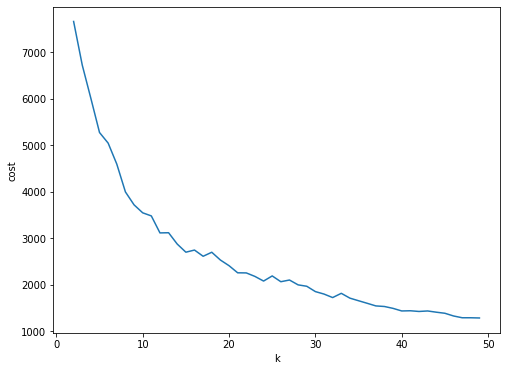

In [ ]:
## plot cost for each k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,50),cost[2:50])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
## make k-means clustering model with k based on previous calculations
## 
k = 30
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

In [ ]:
transformed = model.transform(df_kmeans).select('ID', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(ID=0, prediction=27), Row(ID=6, prediction=13), Row(ID=10, prediction=25)]


In [ ]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+---+----------+
| ID|prediction|
+---+----------+
|  0|        27|
|  6|        13|
| 10|        25|
| 64|        25|
| 73|        26|
| 75|        27|
| 79|        27|
| 95|        19|
| 97|        26|
|107|        27|
|113|        25|
|117|        27|
|127|         2|
|129|         7|
|133|        19|
|137|         4|
|161|        29|
|177|         4|
|181|        18|
|193|        29|
+---+----------+
only showing top 20 rows



In [ ]:
## join predictions with all data frame
df_pred = df_pred.join(allData, 'ID')
df_pred.show()
pddf_pred = df_pred.toPandas().set_index('ID')
pddf_pred

+----+----------+----------+---------+-----------+----+-----+----+---------+-----------+-----------+------------+-----------+---------+
|  ID|prediction|     Years|      MAX|  RoutesNbr|  OS|Flash|  RP|   Region|        <6a|     6a-6c+|      7a-7c+|       =>8a|    Grade|
+----+----------+----------+---------+-----------+----+-----+----+---------+-----------+-----------+------------+-----------+---------+
| 474|        10| 1.2121212|7.2619047| 0.22448115| 1.3|  0.0| 8.7|3.0882354|        0.0|        0.0|  0.11803588| 0.17597087|8.0809965|
| 418|         1| 1.2121212|      7.5| 0.19906819|4.17|  0.0|5.83|1.0294118|        0.0|0.036764707|  0.13692163| 0.10315534| 8.436137|
| 222|        28| 3.3333333| 9.523809|  2.0288014|4.72| 1.35|3.93|2.9411764|        0.0| 0.09191176|   1.2700661|       1.25|7.9595017|
| 270|        12| 2.7272727| 9.523809| 0.41931385|0.47| 0.76|8.78|3.0882354|        0.0|        0.0|         0.0| 0.60679615| 9.663551|
|1127|         8|       0.1|2.3809524|        0.

,prediction,Years,MAX,RoutesNbr,OS,Flash,RP,Region,<6a,6a-6c+,7a-7c+,=>8a,Grade
ID,,,,,,,,,,,,,
474,10,1.212121,7.261905,0.224481,1.30,0.00,8.70,3.088235,0.000000,0.000000,0.118036,0.175971,8.080997
418,1,1.212121,7.500000,0.199068,4.17,0.00,5.83,1.029412,0.000000,0.036765,0.136922,0.103155,8.436137
222,28,3.333333,9.523809,2.028801,4.72,1.35,3.93,2.941176,0.000000,0.091912,1.270066,1.250000,7.959502
270,12,2.727273,9.523809,0.419314,0.47,0.76,8.78,3.088235,0.000000,0.000000,0.000000,0.606796,9.663551
1127,8,0.100000,2.380952,0.100000,0.00,0.00,10.00,5.735294,0.027027,0.000000,0.000000,0.000000,3.115265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,7,0.100000,2.857143,0.076239,2.11,4.21,3.68,0.588235,0.243243,0.183824,0.000000,0.000000,3.084112
1033,3,1.515152,7.142857,0.135536,1.09,1.20,7.31,8.676471,0.108108,0.183824,0.084986,0.006068,5.311526
1105,24,0.100000,2.380952,0.004235,0.00,5.00,0.10,9.411765,0.054054,0.000000,0.000000,0.000000,1.557632


In [ ]:
## calculate which features have biggest variation
stats=pd.DataFrame()
stats["Var"]=pddf_pred.var()
stats.sort_values('Var')

,Var
<6a,0.865479
7a-7c+,1.206417
=>8a,1.220688
6a-6c+,1.357616
RoutesNbr,1.971870
Flash,2.675450
Years,3.029363
OS,3.660444
MAX,4.784830
Grade,5.004951


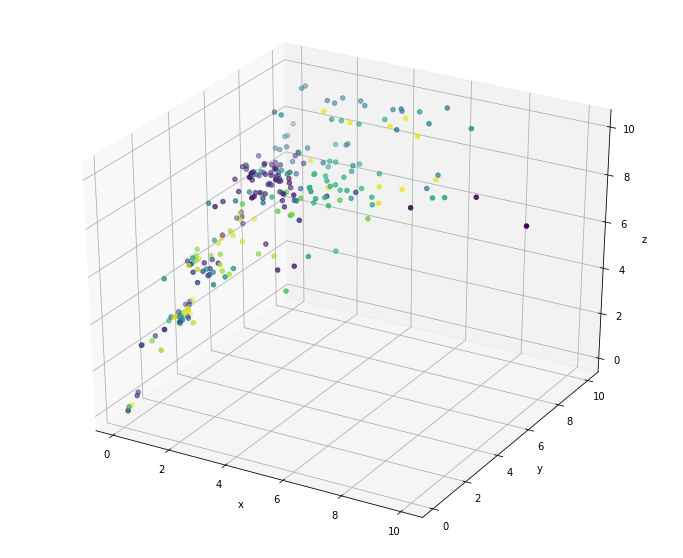

In [ ]:
plot_y_g_m = plt.figure(figsize=(12,10)).gca(projection='3d')
plot_y_g_m.scatter( pddf_pred.Years,pddf_pred.Grade, pddf_pred.MAX, c=pddf_pred.prediction)
plot_y_g_m.set_xlabel('x')
plot_y_g_m.set_ylabel('y')
plot_y_g_m.set_zlabel('z')
plt.show()

**Such a large number of clusters was selected due to the large number of climbing regions**
